In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

from tqdm import tqdm
import yaml

from scipy.stats import binned_statistic_2d
# import shap

from flash_ansr import get_path, ExpressionSpace
from flash_ansr.eval.utils import bootstrapped_metric_ci

In [2]:
space = ExpressionSpace.from_config(get_path('configs', 'v7.0', 'expression_space.yaml'))

In [3]:
def nan_false_statistic(X, statistic):
    X_copy = np.array(X)
    # Where X is nan, replace with False
    X_copy[np.isnan(X_copy)] = False
    return statistic(X_copy)

In [4]:
MODELS = [
    'pysr',
    'nesymres-100M',
    'v7.0',
    'v7.0-mini',
    # 'v7.11',
    # 'analysis_beams_v7.0/v7.0_512-beams'
    # 'v7.1',
    # 'v7.2',
    # 'v7.3',
    # 'v7.4',
    # 'v7.5',
    # 'v7.7',
    # 'v7.10',
    'v7.11',
    'v7.12',
    'v7.20',
    'v8.0',
    'v9.0',
    'v9.1',
]

MODELS_DESCRIPTION = {
    'nesymres-100M': 'NeSymReS 100M',
    'pysr': 'PySR',
}

for model in MODELS:
    if model not in MODELS_DESCRIPTION:
        MODELS_DESCRIPTION[model] = model

In [5]:
TEST_SETS = ['train', 'val', 'feynman', 'soose_nc', 'nguyen', 'pool_15']
TEST_SET_TITLES = {
    'train': 'Train',
    'val': 'Val',
    'feynman': 'Feynman',
    'soose_nc': 'S.-NC',
    'nguyen': 'Nguyen',
    'pool_15': 'Pool-15',
}
TEST_SET_TITLES_LONG = {
    'train': 'Train',
    'val': 'Validation',
    'feynman': 'Feynman',
    'soose_nc': 'SOOSE-NC',
    'nguyen': 'Nguyen',
    'pool_15': 'Pool-15',
}

In [ ]:
configs = {}

for model in MODELS:
    with open(get_path(f'configs/{model}/evaluation.yaml'), 'r') as f:
        configs[model] = yaml.safe_load(f)

In [7]:
test_sets = {model: [path.replace('.pickle', '') for path in os.listdir(get_path(f'results/evaluation/{model}'))] for model in MODELS}

for model, model_test_sets in test_sets.items():
    # Reorder the test sets as follows: train, val, feynman, soose_nc, nguyen
    for i, s in enumerate(TEST_SETS):
        if s in model_test_sets:
            model_test_sets.remove(s)
            model_test_sets.insert(i, s)

In [8]:
results = {}

for model, model_test_sets in test_sets.items():
    results[model] = {test_set: {'path': get_path(f'results/evaluation/{model}/{test_set}.pickle')} for test_set in model_test_sets}

In [9]:
remove_invalid = []

for model, model_results in results.items():
    for test_set, test_set_results in tqdm(model_results.items(), desc=f'Loading {model} results'):
        with open(test_set_results['path'], 'rb') as f:
            test_set_results['data'] = pickle.load(f)

            columns_to_rename = set()
            for k, v in test_set_results['data'].items():
                try:
                    test_set_results['data'][k] = np.array(v)
                except ValueError:
                    pass

                if '_free_' in k:
                    columns_to_rename.add(k)

            for k in columns_to_rename:
                test_set_results['data'][k.replace('_free_', '_')] = test_set_results['data'][k]
                del test_set_results['data'][k]

            keys_to_remove = [k for k in test_set_results['data'].keys() if 'residuals' in k]
            keys_to_remove.extend(['x', 'y', 'y_noisy', 'x_val', 'y_val', 'y_noisy_val'])

            for k in keys_to_remove:
                if k in test_set_results['data']:
                    del test_set_results['data'][k]

Loading v9.1 results: 100%|██████████| 6/6 [02:05<00:00, 20.94s/it]


In [10]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    n_restarts = configs[model].get('n_restarts', 1)
    # Pad the beams to their maximum length
    for test_set, test_set_results in tqdm(model_results.items()):
        data = test_set_results['data']

        if model == 'pysr':
            results[model][test_set]['data']['wall_time'] = data['fit_time']
            results[model][test_set]['data']['sys_time'] = data['fit_time'] * 32  # 32 cores
        
        elif model == 'nesymres-100M':
            results[model][test_set]['data']['wall_time'] = data['fit_time']
            results[model][test_set]['data']['sys_time'] = data['fit_time']

        else:
            if 'beam_search_time' in data:
                results[model][test_set]['data']['wall_time'] = data['beam_search_time'] + sum(data[f'refiner_time_beam_{j + 1}'] for j in range(beam_width))
                results[model][test_set]['data']['sys_time'] = data['beam_search_time'] + sum(data[f'refiner_time_beam_{j + 1}'] for j in range(beam_width))
            elif 'fit_time' in data:
                results[model][test_set]['data']['wall_time'] = data['fit_time']
                results[model][test_set]['data']['sys_time'] = data['fit_time']

100%|██████████| 6/6 [00:00<00:00, 71291.29it/s]


In [11]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    # Pad the beams to their maximum length
    for test_set, test_set_results in tqdm(model_results.items()):
        data = test_set_results['data']
        results[model][test_set]['data']['length_target'] = np.array([len(data['input_ids'][i]) for i in range(len(data['input_ids']))])

        for j in range(beam_width):
            if f'free_beam_{j + 1}' in data:
                results[model][test_set]['data'][f'length_beam_{j + 1}'] = np.array([len(data[f'free_beam_{j + 1}'][i]) if data[f'free_beam_{j + 1}'][i] is not None else None for i in range(len(data[f'free_beam_{j + 1}']))])
            if f'residuals_beam_{j + 1}' in data:
                results[model][test_set]['data'][f'L_inf_beam_{j + 1}'] = np.array([(np.nanmax(np.abs(data[f'residuals_beam_{j + 1}'][i])) if data[f'residuals_beam_{j + 1}'][i] is not None else np.nan) for i in range(len(data[f'residuals_beam_{j + 1}']))])
            if f'log_prob_beam{j + 1}' in data:
                results[model][test_set]['data'][f'log_prob_beam_{j + 1}'] = results[model][test_set]['data'][f'log_prob_beam{j + 1}']
                del results[model][test_set]['data'][f'log_prob_beam{j + 1}']
        
        if '_beam_1' not in data:
            continue

        max_length = max(max([len(beam) for beam in data[f'_beam_{j + 1}']]) for j in range(beam_width))

        for j in range(beam_width):
            padded_beam = [beam + [0] * (max_length - len(beam)) for beam in data[f'_beam_{j + 1}']]
            data[f'_beam_{j + 1}'] = np.array(padded_beam)


100%|██████████| 6/6 [00:00<00:00, 30.01it/s]


In [12]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    for test_set, test_set_results in tqdm(model_results.items()):
        valid = True
        data = test_set_results['data']

        beam_columns = [k.replace('_beam_1', '') for k in data.keys() if k.endswith(f'beam_1') and not 'residuals' in k and not 'free' in k]

        # Create new columns with metrics of the best beam (by mse_{generation_type}_beam_{i}) and store it as {metric}_{generation_type}_best_beam
        # Create new columns
        for column in beam_columns:
            if isinstance(data[column + '_beam_1'][0], np.ndarray):
                data[column + '_best_beam'] = np.nan * np.ones_like(data[column + '_beam_1'])
            else:
                data[column + '_best_beam'] = np.nan * np.ones(len(data[column + '_beam_1']))

        data['best_beam'] = np.nan * np.ones(len(data['mse_beam_1']))

        # For each instance, find the best beam by mse
        for i in range(len(data['mse_beam_1'])):
            mse_list = np.array([data[f'mse_beam_{j}'][i] for j in range(1, beam_width+1) if f'mse_beam_{j}' in data.keys()])
            if np.all(np.isnan(mse_list)):
                continue
            best_beam = np.nanargmin([data[f'mse_beam_{j}'][i] for j in range(1, beam_width+1) if f'mse_beam_{j}' in data.keys()]) + 1
            data['best_beam'][i] = best_beam
            for column in beam_columns:
                data[column + '_best_beam'][i] = data[column + f'_beam_{best_beam}'][i]

100%|██████████| 6/6 [00:01<00:00,  5.45it/s]


In [13]:
# Design features
for model, model_results in results.items():
    for test_set, test_set_results in model_results.items():
        for maybe_val in ['', '_val']:
            test_set_results['data'][f'is_finite{maybe_val}'] = np.array([np.isfinite(r2) for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])

            test_set_results['data'][f'FVU-eps_accuracy{maybe_val}'] = np.array([(1 - r2) <= np.finfo(np.float32).eps for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])

            test_set_results['data'][f'fvu{maybe_val}'] = np.array([1 - r2 for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])
            test_set_results['data'][f'log_fvu{maybe_val}'] = np.array([np.log10(max(1 - r2, np.finfo(np.float32).eps)) for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])

            test_set_results['data'][f'fvu_not_epsilon{maybe_val}'] = np.copy(test_set_results['data'][f'fvu{maybe_val}'])
            test_set_results['data'][f'fvu_not_epsilon{maybe_val}'][test_set_results['data'][f'FVU-eps_accuracy{maybe_val}']] = np.nan

            test_set_results['data'][f'log_fvu_not_epsilon{maybe_val}'] = np.array([np.log10(fvu) for fvu in test_set_results['data'][f'fvu_not_epsilon{maybe_val}']])

        if 'perplexity' in test_set_results['data']:
            test_set_results['data']['log_ppl'] = [np.log10(ppl) for ppl in test_set_results['data']['perplexity']]
        else:
            test_set_results['data']['log_ppl'] = [np.nan] * len(test_set_results['data']['r2_best_beam'])

In [14]:
# Find the intersection of the columns of all the dataframes
compare_columns = set.union(*[set(test_set_results['data'].keys()) for model_results in results.values() for test_set_results in model_results.values()])
compare_columns = compare_columns - {'x', 'y', 'y_noisy', 'x_val', 'y_val', 'y_noisy_val', 'fit_time',  'constants', 'input_ids', 'labels', 'residuals_beam_1', 'n_support', 'free_best_beam', 'y_noisy'}
compare_columns = compare_columns - {c for c in compare_columns if any(c.endswith(f'_{i}') or 'free' in c for i in range(1, 1024))}
# compare_columns = compare_columns.union({'perplexity', 'precision_best_beam', 'recall_best_beam', 'meteor_best_beam', 'edit_distance'})
compare_columns

{'FVU-eps_accuracy',
 'FVU-eps_accuracy_val',
 'NSRTS_accuracy_close_best_beam',
 'NSRTS_accuracy_close_val_best_beam',
 'NSRTS_accuracy_r2_best_beam',
 'NSRTS_accuracy_r2_val_best_beam',
 'accuracy_best_beam',
 'beam_search_time',
 'best_beam',
 'bleu_best_beam',
 'edit_distance_best_beam',
 'f1_score_best_beam',
 'fvu',
 'fvu_not_epsilon',
 'fvu_not_epsilon_val',
 'fvu_val',
 'is_finite',
 'is_finite_val',
 'length_best_beam',
 'length_target',
 'log_fvu',
 'log_fvu_not_epsilon',
 'log_fvu_not_epsilon_val',
 'log_fvu_val',
 'log_ppl',
 'log_prob_best_beam',
 'meteor_best_beam',
 'mse_best_beam',
 'mse_val_best_beam',
 'perplexity',
 'precision_best_beam',
 'r2_best_beam',
 'r2_val_best_beam',
 'recall_best_beam',
 'reciprocal_rank',
 'refiner_time_best_beam',
 'rouge1_fmeasure_best_beam',
 'rouge1_precision_best_beam',
 'rouge1_recall_best_beam',
 'rouge2_fmeasure_best_beam',
 'rouge2_precision_best_beam',
 'rouge2_recall_best_beam',
 'rougeL_fmeasure_best_beam',
 'rougeL_precision_b

In [15]:
array_dfs = {
    model: {
        test_set:
        pd.DataFrame({k: v for k, v in test_set_results['data'].items() if k in compare_columns}).astype(float)
            for test_set, test_set_results in model_results.items()}
            for model, model_results in results.items()}

In [16]:
compare_columns_defaults = {
    'FVU-eps_accuracy': 0,
    'perplexity': np.inf,
    'log_ppl': np.inf,
    'precision_best_beam': 0,
    'recall_best_beam': 0,
    'L_inf_best_beam': np.inf,
    'NSRTS_accuracy_close_best_beam': 0,
    'NSRTS_accuracy_r2_best_beam': 0,
    'NSRTS_accuracy_close_val_best_beam': 0,
    'NSRTS_accuracy_r2_val_best_beam': 0,
    'accuracy_best_beam': 0,
    'bleu_best_beam': 0,
    'edit_distance_best_beam': np.inf,
    'f1_score_best_beam': 0,
    'fvu': np.inf,
    'log_fvu': np.inf,
    'fvu_not_epsilon': np.inf,
    'log_fvu_not_epsilon': np.inf,
    'log_ppl': np.inf,
    'meteor_best_beam': 0,
    'mse_best_beam': np.inf,
    'mse_val_best_beam': np.inf,
    'perplexity': np.inf,
    'precision_best_beam': 0,
    'r2_best_beam': -np.inf,
    'r2_val_best_beam': -np.inf,
    'recall_best_beam': 0,
    'reciprocal_rank': 0,
    'rouge1_fmeasure_best_beam': 0,
    'rouge1_precision_best_beam': 0,
    'rouge1_recall_best_beam': 0,
    'rouge2_fmeasure_best_beam': 0,
    'rouge2_precision_best_beam': 0,
    'rouge2_recall_best_beam': 0,
    'rougeL_fmeasure_best_beam': 0,
    'rougeL_precision_best_beam': 0,
    'rougeL_recall_best_beam': 0,
    'structural_accuracy_best_beam': 0,
    'tree_edit_distance_best_beam': np.inf,
    'wall_time': np.inf,
    'sys_time': np.inf,
    'is_finite': 0,
    'log_prob_best_beam': -np.inf,
}

In [17]:
from functools import partial

In [18]:
def naninfmean(x):
    return np.nanmean(np.array(x)[np.isfinite(x)])

In [19]:
N_BOOTSTRAPS = 1_000

In [20]:
summaries = {model: {test_set: {column: {} for column in compare_columns} for test_set, df in model_dfs.items()} for model, model_dfs in array_dfs.items()}
metrics = None

for model, model_dfs in array_dfs.items():
    for test_set, df in model_dfs.items():
        for column in tqdm(compare_columns, desc=f'{model} {test_set}'):
            sub_metrics = ['mean', 'median', '2.5p', '97.5p']
            sub_metrics_functions = [naninfmean, np.nanmedian, partial(np.nanpercentile, q=2.5), partial(np.nanpercentile, q=97.5)]
            if column in df.columns:
                data = df[column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
                summaries[model][test_set][column] = {m: bootstrapped_metric_ci(data, f, n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}
            else:
                summaries[model][test_set][column] = {k: (np.nan, ) * 3 for k in sub_metrics}

            if metrics is None:
                metrics = summaries[model][test_set][column].keys()

pysr feynman:  16%|█▋        | 8/49 [00:00<00:04,  9.38it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
pysr feynman:  33%|███▎      | 16/49 [00:01<00:04,  8.15it/s]/tmp/ipykernel_1874/3880369273.py:2: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.array(x)[np.isfinite(x)])
nesymres-100M soose_nc:  88%|████████▊ | 43/49 [00:04<00:00, 10.48it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4622: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
nesymres-100M pool_15:   4%|▍         | 2/49 [00:00<00:04,  9.64it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4623: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out

In [21]:
def ar_test(data1, data2, test_statistic, n):
    # Compute the observed test statistic.
    obs_stat = test_statistic(data1, data2)

    # Pool the data from both samples.
    pooled_data = np.concatenate((data1, data2))
    n1 = len(data1)
    
    # Count the number of times the permuted statistic is at least as extreme as the observed.
    extreme_count = 0
    for _ in range(n):
        # Permute the pooled data.
        permuted = np.random.permutation(pooled_data)
        # Split into two groups (using the original sample sizes).
        perm_group1 = permuted[:n1]
        perm_group2 = permuted[n1:]
        # Compute the test statistic for the permutation.
        perm_stat = test_statistic(perm_group1, perm_group2)
        # For a two-sided test: count if the absolute value is at least as extreme.
        if abs(perm_stat) >= abs(obs_stat):
            extreme_count += 1
    
    # Compute the p-value (with a small correction to avoid a zero p-value).
    p_value = (extreme_count) / (n)
    
    return obs_stat, p_value

In [22]:
ar_p = {model: {test_set: {column: {} for column in compare_columns} for test_set, df in model_dfs.items()} for model, model_dfs in array_dfs.items()}
metrics = None

reference_model = 'v7.0'

for model, model_dfs in array_dfs.items():
    for test_set, df in model_dfs.items():
        for column in tqdm(compare_columns, desc=f'{model} {test_set}'):
            sub_metrics = ['mean', 'median', '2.5p', '97.5p']
            sub_metrics_functions = [naninfmean, np.nanmedian, partial(np.nanpercentile, q=2.5), partial(np.nanpercentile, q=97.5)]
            if column in df.columns:
                data = df[column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
                if column not in array_dfs[reference_model][test_set].columns:
                    ar_p[model][test_set][column] = {k: (np.nan, ) * 2 for k in sub_metrics}
                else:
                    ar_p[model][test_set][column] = {m: ar_test(array_dfs[reference_model][test_set][column], data, lambda x, y: f(x) - f(y), n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}
            else:
                ar_p[model][test_set][column] = {k: (np.nan, ) * 2 for k in sub_metrics}

            if metrics is None:
                metrics = ar_p[model][test_set][column].keys()

pysr feynman:  33%|███▎      | 16/49 [00:07<00:16,  1.96it/s]/tmp/ipykernel_1874/3880369273.py:2: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.array(x)[np.isfinite(x)])
v7.0 feynman:  16%|█▋        | 8/49 [00:06<00:30,  1.34it/s]/tmp/ipykernel_1874/2482539548.py:16: RuntimeWarning: invalid value encountered in scalar subtract
  ar_p[model][test_set][column] = {m: ar_test(array_dfs[reference_model][test_set][column], data, lambda x, y: f(x) - f(y), n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}
v9.1 pool_15: 100%|██████████| 49/49 [00:33<00:00,  1.45it/s]


In [23]:
# Show a summary table for each metric
# In each table, the rows are the models and the columns are the test sets
# For columns with 'accuracy' in the name, show the mean. For other columns show the median.

summary_tables = {
    column: {
        metric: {
            percentile:
                pd.DataFrame({
                model: {
                    test_set: summaries[model][test_set][column][metric][k]
                    for test_set in summaries[model].keys()}
                    for model in summaries.keys()}).T.round(3)
                    for k, percentile in enumerate(['median', 'lower', 'upper'])}
                    for metric in metrics}
                    for column in compare_columns}

In [24]:
# Show a summary table for each metric
# In each table, the rows are the models and the columns are the test sets
# For columns with 'accuracy' in the name, show the mean. For other columns show the median.

ar_tables = {
    column: {
        metric: {
            value:
                pd.DataFrame({
                model: {
                    test_set: ar_p[model][test_set][column][metric][k]
                    for test_set in ar_p[model].keys()}
                    for model in ar_p.keys()}).T.round(3)
                    for k, value in enumerate(['statistic', 'p'])}
                    for metric in metrics}
                    for column in compare_columns}

#### Validity

In [25]:
m = 'is_finite'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15,train,val
pysr,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","nan (nan, nan)","nan (nan, nan)"
nesymres-100M,"0.945 (0.93, 0.959)","0.955 (0.941, 0.968)","0.923 (0.905, 0.939)","0.941 (0.927, 0.956)","nan (nan, nan)","nan (nan, nan)"
v7.0,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (0.999, 1.0)","1.0 (0.999, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
v7.0-mini,"1.0 (1.0, 1.0)","1.0 (0.999, 1.0)","1.0 (1.0, 1.0)","1.0 (0.999, 1.0)","1.0 (1.0, 1.0)","0.999 (0.999, 1.0)"
v7.11,"1.0 (1.0, 1.0)","1.0 (0.999, 1.0)","1.0 (1.0, 1.0)","0.999 (0.999, 1.0)","0.999 (0.998, 1.0)","0.999 (0.998, 1.0)"
v7.12,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (0.999, 1.0)","1.0 (0.999, 1.0)","1.0 (0.999, 1.0)"
v7.20,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (0.999, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
v8.0,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (0.999, 1.0)","1.0 (1.0, 1.0)"
v9.0,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (0.999, 1.0)","1.0 (0.999, 1.0)","1.0 (1.0, 1.0)"
v9.1,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (0.999, 1.0)","1.0 (0.999, 1.0)","1.0 (1.0, 1.0)"


#### Recovery Rate

In [26]:
m = 'NSRTS_accuracy_close_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15,train,val
pysr,"0.855 (0.831, 0.877)","0.773 (0.747, 0.798)","0.892 (0.874, 0.912)","0.639 (0.607, 0.668)","nan (nan, nan)","nan (nan, nan)"
nesymres-100M,"0.661 (0.634, 0.691)","0.422 (0.392, 0.453)","0.638 (0.609, 0.665)","0.287 (0.259, 0.313)","nan (nan, nan)","nan (nan, nan)"
v7.0,"0.883 (0.873, 0.891)","0.822 (0.811, 0.832)","0.88 (0.87, 0.889)","0.648 (0.635, 0.661)","0.752 (0.74, 0.764)","0.75 (0.738, 0.762)"
v7.0-mini,"0.747 (0.735, 0.759)","0.511 (0.497, 0.525)","0.643 (0.63, 0.656)","0.508 (0.494, 0.521)","0.548 (0.535, 0.564)","0.552 (0.538, 0.565)"
v7.11,"0.892 (0.883, 0.9)","0.734 (0.722, 0.746)","0.906 (0.898, 0.915)","0.652 (0.639, 0.665)","0.373 (0.36, 0.386)","0.371 (0.358, 0.383)"
v7.12,"0.833 (0.823, 0.844)","0.747 (0.736, 0.758)","0.763 (0.751, 0.774)","0.574 (0.561, 0.588)","0.67 (0.658, 0.683)","0.657 (0.644, 0.67)"
v7.20,"0.875 (0.866, 0.883)","0.804 (0.793, 0.814)","0.888 (0.879, 0.897)","0.616 (0.603, 0.63)","0.719 (0.706, 0.731)","0.725 (0.712, 0.737)"
v8.0,"0.834 (0.824, 0.845)","0.753 (0.741, 0.764)","0.865 (0.856, 0.874)","0.594 (0.581, 0.609)","0.676 (0.663, 0.688)","0.681 (0.667, 0.694)"
v9.0,"0.854 (0.845, 0.864)","0.823 (0.813, 0.834)","0.878 (0.869, 0.887)","0.615 (0.602, 0.628)","0.725 (0.714, 0.737)","0.733 (0.721, 0.746)"
v9.1,"0.852 (0.842, 0.862)","0.807 (0.795, 0.818)","0.908 (0.899, 0.916)","0.607 (0.593, 0.621)","0.718 (0.705, 0.73)","0.715 (0.703, 0.727)"


In [27]:
m = 'NSRTS_accuracy_r2_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15,train,val
pysr,"0.954 (0.94, 0.966)","0.86 (0.838, 0.882)","0.958 (0.946, 0.969)","0.871 (0.851, 0.891)","nan (nan, nan)","nan (nan, nan)"
nesymres-100M,"0.777 (0.749, 0.803)","0.603 (0.572, 0.63)","0.792 (0.767, 0.818)","0.442 (0.412, 0.474)","nan (nan, nan)","nan (nan, nan)"
v7.0,"0.937 (0.93, 0.944)","0.878 (0.869, 0.887)","0.985 (0.982, 0.989)","0.83 (0.82, 0.841)","0.893 (0.885, 0.902)","0.892 (0.884, 0.901)"
v7.0-mini,"0.857 (0.848, 0.867)","0.669 (0.657, 0.682)","0.847 (0.836, 0.857)","0.709 (0.697, 0.721)","0.802 (0.791, 0.814)","0.789 (0.778, 0.801)"
v7.11,"0.952 (0.946, 0.957)","0.824 (0.813, 0.834)","0.977 (0.973, 0.981)","0.832 (0.821, 0.842)","0.747 (0.735, 0.759)","0.726 (0.714, 0.739)"
v7.12,"0.921 (0.914, 0.929)","0.829 (0.819, 0.839)","0.953 (0.947, 0.959)","0.757 (0.745, 0.768)","0.852 (0.843, 0.863)","0.842 (0.832, 0.852)"
v7.20,"0.934 (0.927, 0.94)","0.862 (0.852, 0.87)","0.984 (0.981, 0.987)","0.808 (0.797, 0.818)","0.874 (0.865, 0.884)","0.883 (0.874, 0.891)"
v8.0,"0.918 (0.91, 0.926)","0.841 (0.831, 0.851)","0.976 (0.971, 0.98)","0.783 (0.771, 0.794)","0.854 (0.844, 0.862)","0.872 (0.863, 0.881)"
v9.0,"0.911 (0.902, 0.919)","0.869 (0.859, 0.877)","0.989 (0.986, 0.992)","0.8 (0.789, 0.811)","0.882 (0.873, 0.891)","0.877 (0.867, 0.886)"
v9.1,"0.911 (0.903, 0.92)","0.86 (0.851, 0.869)","0.986 (0.983, 0.989)","0.786 (0.775, 0.797)","0.868 (0.86, 0.877)","0.871 (0.861, 0.88)"


In [28]:
m = 'FVU-eps_accuracy'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15,train,val
pysr,"0.692 (0.661, 0.72)","0.606 (0.577, 0.635)","0.794 (0.767, 0.819)","0.353 (0.325, 0.381)","nan (nan, nan)","nan (nan, nan)"
nesymres-100M,"0.513 (0.483, 0.545)","0.265 (0.238, 0.292)","0.542 (0.512, 0.57)","0.112 (0.094, 0.132)","nan (nan, nan)","nan (nan, nan)"
v7.0,"0.759 (0.748, 0.77)","0.708 (0.695, 0.721)","0.749 (0.737, 0.761)","0.364 (0.35, 0.376)","0.56 (0.547, 0.575)","0.566 (0.551, 0.58)"
v7.0-mini,"0.629 (0.615, 0.642)","0.335 (0.321, 0.347)","0.44 (0.426, 0.452)","0.24 (0.228, 0.252)","0.354 (0.342, 0.367)","0.355 (0.341, 0.368)"
v7.11,"0.753 (0.741, 0.765)","0.584 (0.57, 0.596)","0.775 (0.763, 0.787)","0.355 (0.341, 0.367)","0.159 (0.148, 0.168)","0.158 (0.148, 0.168)"
v7.12,"0.726 (0.713, 0.739)","0.631 (0.618, 0.644)","0.57 (0.556, 0.584)","0.296 (0.284, 0.309)","0.553 (0.539, 0.567)","0.534 (0.521, 0.549)"
v7.20,"0.752 (0.739, 0.764)","0.7 (0.687, 0.713)","0.763 (0.751, 0.776)","0.36 (0.348, 0.374)","0.522 (0.507, 0.534)","0.547 (0.532, 0.56)"
v8.0,"0.682 (0.669, 0.695)","0.596 (0.583, 0.61)","0.716 (0.704, 0.728)","0.312 (0.299, 0.324)","0.452 (0.438, 0.466)","0.458 (0.444, 0.471)"
v9.0,"0.753 (0.741, 0.765)","0.747 (0.734, 0.758)","0.789 (0.777, 0.8)","0.345 (0.333, 0.358)","0.55 (0.536, 0.563)","0.546 (0.531, 0.56)"
v9.1,"0.748 (0.736, 0.76)","0.716 (0.704, 0.729)","0.817 (0.806, 0.826)","0.357 (0.342, 0.37)","0.54 (0.526, 0.554)","0.549 (0.534, 0.563)"


In [29]:
m = 'FVU-eps_accuracy'
sm = 'mean'
ar_tables[m][sm]['p']

,feynman,soose_nc,nguyen,pool_15,train,val
pysr,0.000,0.000,0.006,0.514,NaN,NaN
nesymres-100M,0.000,0.000,0.000,0.000,NaN,NaN
v7.0,1.000,1.000,1.000,1.000,1.000,1.000
v7.0-mini,0.000,0.000,0.000,0.000,0.000,0.000
v7.11,0.512,0.000,0.001,0.361,0.000,0.000
v7.12,0.000,0.000,0.000,0.000,0.481,0.001
v7.20,0.431,0.415,0.116,0.806,0.000,0.068
v8.0,0.000,0.000,0.000,0.000,0.000,0.000
v9.0,0.512,0.000,0.000,0.064,0.332,0.067
v9.1,0.196,0.348,0.000,0.462,0.037,0.087


In [30]:
m = 'FVU-eps_accuracy_val'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15,train,val
pysr,"0.682 (0.652, 0.708)","0.598 (0.568, 0.629)","0.79 (0.765, 0.815)","0.34 (0.307, 0.37)","nan (nan, nan)","nan (nan, nan)"
nesymres-100M,"0.508 (0.478, 0.539)","0.264 (0.236, 0.291)","0.542 (0.512, 0.575)","0.11 (0.093, 0.129)","nan (nan, nan)","nan (nan, nan)"
v7.0,"0.756 (0.745, 0.768)","0.708 (0.696, 0.72)","0.749 (0.737, 0.761)","0.358 (0.345, 0.372)","0.554 (0.541, 0.568)","0.563 (0.549, 0.576)"
v7.0-mini,"0.629 (0.615, 0.641)","0.333 (0.32, 0.346)","0.439 (0.426, 0.452)","0.235 (0.223, 0.247)","0.347 (0.334, 0.36)","0.35 (0.337, 0.363)"
v7.11,"0.751 (0.738, 0.763)","0.583 (0.568, 0.596)","0.775 (0.763, 0.786)","0.35 (0.336, 0.363)","0.149 (0.139, 0.158)","0.142 (0.132, 0.152)"
v7.12,"0.724 (0.712, 0.735)","0.63 (0.615, 0.644)","0.569 (0.555, 0.584)","0.294 (0.283, 0.307)","0.55 (0.535, 0.563)","0.53 (0.517, 0.543)"
v7.20,"0.75 (0.738, 0.761)","0.7 (0.687, 0.712)","0.762 (0.751, 0.775)","0.355 (0.344, 0.369)","0.516 (0.502, 0.53)","0.539 (0.525, 0.553)"
v8.0,"0.682 (0.669, 0.696)","0.596 (0.582, 0.611)","0.716 (0.704, 0.729)","0.308 (0.295, 0.32)","0.446 (0.433, 0.46)","0.451 (0.437, 0.464)"
v9.0,"0.751 (0.739, 0.764)","0.746 (0.734, 0.757)","0.789 (0.778, 0.8)","0.342 (0.329, 0.355)","0.543 (0.53, 0.557)","0.543 (0.53, 0.558)"
v9.1,"0.746 (0.734, 0.758)","0.717 (0.704, 0.729)","0.817 (0.806, 0.827)","0.353 (0.34, 0.366)","0.536 (0.523, 0.55)","0.544 (0.529, 0.558)"


#### Numeric Error

In [31]:
m = 'fvu_not_epsilon'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15,train,val
pysr,"0.048 (0.032, 0.068)","0.213 (0.17, 0.279)","0.052 (0.036, 0.071)","0.198 (0.077, 0.442)","nan (nan, nan)","nan (nan, nan)"
nesymres-100M,"0.228 (0.193, 0.264)","9626.963 (0.365, 30132.632)","0.179 (0.151, 0.21)","10498853761071.172 (455.561, 32075131305486.754)","nan (nan, nan)","nan (nan, nan)"
v7.0,"0.18 (0.159, 0.2)","0.372 (0.335, 0.434)","0.013 (0.01, 0.018)","0.194 (0.163, 0.236)","0.158 (0.145, 0.174)","0.157 (0.144, 0.171)"
v7.0-mini,"0.246 (0.227, 0.265)","0.387 (0.367, 0.408)","0.17 (0.158, 0.183)","1.2640923087056286e+298 (0.224, 3.840573368794...","0.194 (0.171, 0.224)","0.234 (0.194, 0.309)"
v7.11,"0.142 (0.123, 0.166)","0.464 (0.371, 0.643)","0.046 (0.027, 0.079)","0.632 (0.25, 1.19)","18.055 (0.229, 53.767)","90745465891243.75 (0.258, 275341876235017.22)"
v7.12,"0.2 (0.179, 0.222)","104652474663317.8 (0.427, 327849775954470.4)","0.045 (0.038, 0.052)","0.262 (0.228, 0.313)","0.291 (0.249, 0.368)","0.255 (0.238, 0.273)"
v7.20,"0.176 (0.156, 0.196)","0.41 (0.382, 0.438)","0.016 (0.013, 0.021)","0.291 (0.185, 0.504)","0.176 (0.161, 0.192)","0.169 (0.153, 0.184)"
v8.0,"0.164 (0.147, 0.181)","0.325 (0.304, 0.347)","0.025 (0.02, 0.031)","1013621.844 (0.3, 3096957.506)","0.167 (0.153, 0.184)","0.152 (0.139, 0.168)"
v9.0,"1275081.472 (0.246, 4007268.1)","0.455 (0.426, 0.486)","0.013 (0.009, 0.017)","0.317 (0.192, 0.545)","0.166 (0.152, 0.182)","0.176 (0.161, 0.192)"
v9.1,"0.267 (0.238, 0.302)","1.026 (0.416, 2.275)","0.033 (0.021, 0.049)","21036.692 (1.007, 53043.994)","0.194 (0.179, 0.212)","0.186 (0.169, 0.203)"


In [32]:
m = 'fvu_not_epsilon_val'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15,train,val
pysr,"1.203 (0.308, 3.027)","3.284 (1.426, 6.266)","0.054 (0.038, 0.075)","2.082939706320037e+34 (7.509, 6.38365496324657...","nan (nan, nan)","nan (nan, nan)"
nesymres-100M,"125484.347 (17.9, 437812.305)","28.361 (2.588, 79.198)","0.184 (0.155, 0.215)","9766089059861.158 (259.256, 29983897651470.8)","nan (nan, nan)","nan (nan, nan)"
v7.0,"1734.126 (112.788, 4363.211)","120.732 (3.683, 379.145)","0.013 (0.01, 0.017)","3.8422553649661823e+77 (564763.358, 1.17006783...","1.3032764666784592e+19 (42979.215, 3.421140616...","4.070701559249279e+238 (1997545422.152, 1.2488..."
v7.0-mini,"1.7306875382386595e+23 (69.074, 5.397199854768...","513.355 (3.199, 1580.148)","0.172 (0.16, 0.185)","5.19406569727416e+36 (360902079.538, 1.5780378...","16296868142.682 (2085.331, 49694299109.411)","1.6383305059123554e+70 (3629.284, 4.9499848980..."
v7.11,"40086.456 (41.354, 125070.223)","16.563 (2.569, 36.692)","0.046 (0.029, 0.08)","1.781506207621129e+23 (228.447, 5.450031549360...","1.31375784950834e+295 (6.151942458375526e+18, ...",2.2582517745615092e+192 (1.4077412755139156e+1...
v7.12,"4916108.155 (446.671, 15273948.354)","101456801104849.14 (1.96, 310966000028124.75)","0.045 (0.039, 0.053)","9.796466265419043e+66 (7218.494, 2.99334206428...","2.623454270550261e+32 (115.906, 8.009321849636...",9.689169606595715e+177 (1.7314606619813023e+18...
v7.20,"34.439 (8.472, 77.982)","749.324 (2.552, 2333.042)","0.016 (0.013, 0.021)","78341636445.631 (75.855, 239217569287.101)","27226.28 (507.307, 81805.544)","6.188377114894637e+129 (5179.758, 1.8874550200..."
v8.0,"2.489063237235481e+33 (215.614, 7.737521561843...","48.214 (7.934, 131.878)","0.026 (0.021, 0.031)","4022545.673 (419967.494, 10354607.979)","4.814624409548606e+87 (9.77, 1.485308795593304...","35849664.251 (82.467, 101591857.758)"
v9.0,"2.8924762852459915e+94 (455.094, 9.27621082583...","25.753 (1.945, 74.09)","0.013 (0.01, 0.018)","15035583336.243 (472961.431, 46001112567.086)","129967906562.052 (595.482, 393925734024.433)","165715944469.391 (125.623, 507426175850.079)"
v9.1,"76438.838 (372.068, 191626.779)","12.917 (1.942, 34.456)","0.032 (0.021, 0.048)","8.161241486528454e+16 (1556041.571, 2.48204909...","7306607619918.996 (1784587.466, 22558506320682...","1.041067153557556e+177 (181.246, 3.28721757542..."


In [33]:
m = 'wall_time'
sm = 'median'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15,train,val
pysr,"3.885 (3.829, 3.94)","3.998 (3.957, 4.045)","3.75 (3.712, 3.784)","4.299 (4.254, 4.341)","nan (nan, nan)","nan (nan, nan)"
nesymres-100M,"84.646 (83.215, 85.993)","84.976 (83.05, 87.037)","85.128 (83.263, 87.525)","88.513 (86.549, 90.589)","nan (nan, nan)","nan (nan, nan)"
v7.0,"0.996 (0.994, 0.998)","0.986 (0.984, 0.988)","0.998 (0.996, 0.999)","1.029 (1.025, 1.033)","1.003 (1.0, 1.005)","1.006 (1.004, 1.009)"
v7.0-mini,"0.348 (0.347, 0.35)","0.352 (0.35, 0.354)","0.355 (0.353, 0.357)","0.37 (0.367, 0.373)","0.359 (0.358, 0.361)","0.348 (0.347, 0.35)"
v7.11,"1.084 (1.08, 1.087)","1.104 (1.098, 1.109)","1.066 (1.057, 1.073)","1.18 (1.17, 1.191)","1.206 (1.195, 1.213)","1.205 (1.196, 1.213)"
v7.12,"0.678 (0.677, 0.68)","0.665 (0.663, 0.666)","0.665 (0.664, 0.668)","0.686 (0.684, 0.689)","0.67 (0.669, 0.671)","0.663 (0.662, 0.664)"
v7.20,"0.693 (0.692, 0.694)","0.699 (0.698, 0.701)","0.688 (0.687, 0.69)","0.753 (0.748, 0.757)","0.728 (0.725, 0.73)","0.718 (0.716, 0.721)"
v8.0,"0.619 (0.618, 0.621)","0.61 (0.608, 0.611)","0.614 (0.612, 0.616)","0.646 (0.644, 0.649)","0.624 (0.622, 0.626)","0.624 (0.622, 0.626)"
v9.0,"0.62 (0.618, 0.622)","0.635 (0.632, 0.636)","0.632 (0.631, 0.632)","0.603 (0.593, 0.61)","0.5 (0.484, 0.521)","0.496 (0.481, 0.513)"
v9.1,"0.636 (0.635, 0.637)","0.342 (0.311, 0.372)","0.634 (0.633, 0.634)","0.552 (0.537, 0.562)","0.431 (0.421, 0.438)","0.428 (0.42, 0.437)"


In [34]:
m = 'sys_time'
sm = 'median'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15,train,val
pysr,"124.432 (122.429, 126.14)","127.924 (126.632, 129.53)","120.054 (118.854, 121.047)","137.583 (136.123, 138.926)","nan (nan, nan)","nan (nan, nan)"
nesymres-100M,"84.646 (83.217, 85.988)","85.09 (82.905, 87.106)","85.083 (83.263, 87.601)","88.525 (86.747, 90.808)","nan (nan, nan)","nan (nan, nan)"
v7.0,"0.996 (0.993, 0.998)","0.986 (0.984, 0.988)","0.998 (0.996, 0.999)","1.029 (1.025, 1.033)","1.003 (1.0, 1.005)","1.006 (1.004, 1.009)"
v7.0-mini,"0.348 (0.346, 0.35)","0.352 (0.35, 0.353)","0.355 (0.353, 0.357)","0.37 (0.367, 0.373)","0.36 (0.358, 0.361)","0.348 (0.346, 0.35)"
v7.11,"1.084 (1.08, 1.087)","1.104 (1.098, 1.109)","1.066 (1.056, 1.073)","1.18 (1.17, 1.191)","1.206 (1.195, 1.213)","1.205 (1.196, 1.213)"
v7.12,"0.678 (0.677, 0.68)","0.665 (0.663, 0.666)","0.665 (0.664, 0.668)","0.686 (0.684, 0.689)","0.67 (0.669, 0.671)","0.663 (0.662, 0.664)"
v7.20,"0.693 (0.692, 0.694)","0.699 (0.698, 0.701)","0.688 (0.687, 0.69)","0.753 (0.747, 0.757)","0.728 (0.725, 0.73)","0.718 (0.716, 0.721)"
v8.0,"0.619 (0.618, 0.621)","0.61 (0.608, 0.612)","0.614 (0.612, 0.616)","0.646 (0.644, 0.649)","0.624 (0.622, 0.627)","0.624 (0.622, 0.626)"
v9.0,"0.62 (0.618, 0.622)","0.635 (0.632, 0.636)","0.632 (0.631, 0.632)","0.603 (0.592, 0.611)","0.499 (0.484, 0.521)","0.496 (0.481, 0.515)"
v9.1,"0.636 (0.635, 0.637)","0.342 (0.31, 0.372)","0.634 (0.633, 0.634)","0.551 (0.538, 0.562)","0.431 (0.423, 0.44)","0.428 (0.419, 0.437)"


In [35]:
m = 'perplexity'
sm = 'median'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15,train,val
pysr,"nan (nan, nan)","nan (nan, nan)","nan (nan, nan)","nan (nan, nan)","nan (nan, nan)","nan (nan, nan)"
nesymres-100M,"nan (nan, nan)","nan (nan, nan)","nan (nan, nan)","nan (nan, nan)","nan (nan, nan)","nan (nan, nan)"
v7.0,"2.287 (2.198, 2.388)","2.002 (1.956, 2.075)","5.06 (4.72, 5.366)","16.174 (14.741, 17.413)","4.154 (3.981, 4.358)","4.135 (3.921, 4.325)"
v7.0-mini,"2.843 (2.726, 2.97)","4.644 (4.497, 4.8)","6.551 (6.339, 6.774)","19.907 (18.636, 21.481)","7.4 (7.107, 7.767)","7.544 (7.208, 7.951)"
v7.11,"1.965 (1.922, 2.02)","2.721 (2.639, 2.798)","3.958 (3.699, 4.174)","8.9 (8.559, 9.229)","11.543 (11.099, 11.977)","11.448 (11.075, 11.81)"
v7.12,"2.045 (1.909, 2.216)","2.693 (2.593, 2.838)","5.316 (4.993, 5.712)","21.602 (20.314, 23.141)","3.389 (3.218, 3.568)","3.708 (3.508, 3.868)"
v7.20,"12.96 (12.013, 14.028)","2.333 (2.262, 2.42)","5.532 (5.061, 6.09)","66.424 (59.217, 74.795)","5.973 (5.687, 6.352)","5.981 (5.696, 6.342)"
v8.0,"3.945 (3.663, 4.225)","3.021 (2.896, 3.127)","8.843 (7.806, 9.7)","45.551 (41.206, 54.149)","7.001 (6.613, 7.536)","7.518 (7.047, 8.062)"
v9.0,"1.361 (1.335, 1.386)","1.62 (1.58, 1.646)","2.364 (2.164, 2.601)","9.971 (9.243, 10.619)","3.022 (2.895, 3.127)","2.988 (2.857, 3.115)"
v9.1,"1.346 (1.326, 1.366)","1.6 (1.563, 1.627)","1.824 (1.694, 1.958)","10.071 (9.205, 10.813)","2.913 (2.798, 3.026)","2.881 (2.754, 3.012)"


In [36]:
m = 'tree_edit_distance_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15,train,val
pysr,"25.735 (24.479, 27.064)","27.06 (25.915, 28.3)","27.172 (26.029, 28.233)","39.16 (38.053, 40.189)","nan (nan, nan)","nan (nan, nan)"
nesymres-100M,"18.359 (17.588, 19.177)","21.679 (21.102, 22.246)","20.733 (19.723, 21.662)","32.479 (31.825, 33.141)","nan (nan, nan)","nan (nan, nan)"
v7.0,"11.088 (10.828, 11.351)","7.648 (7.417, 7.877)","12.465 (12.142, 12.793)","21.907 (21.552, 22.237)","14.345 (14.092, 14.622)","14.046 (13.776, 14.324)"
v7.0-mini,"11.817 (11.527, 12.101)","13.231 (12.993, 13.477)","15.736 (15.431, 16.031)","23.754 (23.419, 24.057)","16.677 (16.399, 16.931)","16.701 (16.446, 16.953)"
v7.11,"14.369 (13.979, 14.73)","15.634 (15.225, 16.049)","15.614 (15.249, 15.942)","27.727 (27.354, 28.164)","34.978 (34.68, 35.288)","35.06 (34.754, 35.35)"
v7.12,"10.089 (9.78, 10.352)","7.021 (6.798, 7.217)","12.502 (12.17, 12.785)","22.518 (22.16, 22.861)","11.963 (11.681, 12.279)","11.96 (11.66, 12.253)"
v7.20,"12.043 (11.792, 12.298)","7.824 (7.598, 8.057)","11.805 (11.533, 12.102)","22.965 (22.621, 23.268)","16.271 (15.984, 16.555)","15.916 (15.612, 16.195)"
v8.0,"12.112 (11.863, 12.381)","9.704 (9.442, 9.952)","13.306 (12.952, 13.637)","23.149 (22.772, 23.452)","16.026 (15.765, 16.299)","15.906 (15.643, 16.181)"
v9.0,"10.053 (9.755, 10.363)","5.161 (4.969, 5.348)","11.125 (10.79, 11.46)","22.789 (22.415, 23.182)","14.37 (14.068, 14.675)","14.309 (14.012, 14.613)"
v9.1,"9.499 (9.193, 9.777)","5.35 (5.15, 5.527)","11.014 (10.653, 11.376)","22.613 (22.206, 22.99)","14.361 (14.042, 14.682)","14.164 (13.851, 14.454)"


In [37]:
m = 'f1_score_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15,train,val
pysr,"0.748 (0.74, 0.755)","0.702 (0.691, 0.713)","0.579 (0.566, 0.591)","0.679 (0.669, 0.689)","nan (nan, nan)","nan (nan, nan)"
nesymres-100M,"0.783 (0.768, 0.796)","0.703 (0.691, 0.716)","0.654 (0.636, 0.671)","0.7 (0.686, 0.712)","nan (nan, nan)","nan (nan, nan)"
v7.0,"0.918 (0.916, 0.921)","0.906 (0.902, 0.91)","0.834 (0.83, 0.838)","0.858 (0.855, 0.861)","0.891 (0.888, 0.894)","0.889 (0.886, 0.892)"
v7.0-mini,"0.888 (0.884, 0.891)","0.798 (0.793, 0.803)","0.727 (0.722, 0.731)","0.802 (0.798, 0.806)","0.832 (0.828, 0.836)","0.832 (0.828, 0.835)"
v7.11,"0.916 (0.913, 0.919)","0.869 (0.865, 0.873)","0.805 (0.8, 0.81)","0.856 (0.852, 0.858)","0.847 (0.845, 0.85)","0.85 (0.847, 0.852)"
v7.12,"0.919 (0.916, 0.922)","0.885 (0.88, 0.889)","0.795 (0.79, 0.8)","0.82 (0.816, 0.823)","0.911 (0.908, 0.914)","0.908 (0.905, 0.912)"
v7.20,"0.891 (0.889, 0.894)","0.887 (0.883, 0.892)","0.815 (0.811, 0.82)","0.828 (0.825, 0.832)","0.857 (0.853, 0.86)","0.861 (0.857, 0.864)"
v8.0,"0.887 (0.884, 0.89)","0.864 (0.859, 0.868)","0.786 (0.78, 0.791)","0.823 (0.819, 0.826)","0.85 (0.846, 0.853)","0.851 (0.848, 0.855)"
v9.0,"0.93 (0.927, 0.933)","0.916 (0.912, 0.919)","0.812 (0.807, 0.818)","0.842 (0.839, 0.846)","0.875 (0.871, 0.879)","0.873 (0.869, 0.876)"
v9.1,"0.932 (0.929, 0.934)","0.913 (0.909, 0.917)","0.819 (0.814, 0.825)","0.84 (0.836, 0.843)","0.874 (0.87, 0.877)","0.877 (0.874, 0.881)"


In [38]:
m = 'meteor_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15,train,val
pysr,"0.359 (0.352, 0.366)","0.408 (0.398, 0.42)","0.378 (0.368, 0.388)","0.312 (0.305, 0.32)","nan (nan, nan)","nan (nan, nan)"
nesymres-100M,"0.537 (0.521, 0.552)","0.464 (0.45, 0.478)","0.511 (0.493, 0.531)","0.326 (0.317, 0.335)","nan (nan, nan)","nan (nan, nan)"
v7.0,"0.737 (0.731, 0.744)","0.786 (0.778, 0.793)","0.63 (0.621, 0.638)","0.529 (0.523, 0.535)","0.644 (0.637, 0.651)","0.65 (0.644, 0.657)"
v7.0-mini,"0.693 (0.686, 0.7)","0.597 (0.59, 0.605)","0.472 (0.464, 0.48)","0.451 (0.445, 0.457)","0.55 (0.544, 0.557)","0.546 (0.539, 0.553)"
v7.11,"0.726 (0.718, 0.733)","0.692 (0.684, 0.7)","0.632 (0.624, 0.64)","0.536 (0.53, 0.541)","0.46 (0.456, 0.464)","0.456 (0.452, 0.46)"
v7.12,"0.745 (0.738, 0.752)","0.757 (0.75, 0.765)","0.589 (0.58, 0.598)","0.471 (0.464, 0.478)","0.74 (0.733, 0.746)","0.735 (0.729, 0.742)"
v7.20,"0.68 (0.673, 0.687)","0.766 (0.758, 0.773)","0.648 (0.64, 0.656)","0.498 (0.493, 0.505)","0.625 (0.619, 0.632)","0.631 (0.625, 0.638)"
v8.0,"0.701 (0.695, 0.708)","0.727 (0.72, 0.735)","0.599 (0.59, 0.607)","0.497 (0.491, 0.503)","0.597 (0.59, 0.604)","0.598 (0.592, 0.605)"
v9.0,"0.761 (0.754, 0.767)","0.821 (0.815, 0.827)","0.696 (0.687, 0.705)","0.55 (0.543, 0.557)","0.663 (0.656, 0.67)","0.663 (0.656, 0.67)"
v9.1,"0.772 (0.765, 0.779)","0.811 (0.804, 0.818)","0.706 (0.696, 0.714)","0.55 (0.543, 0.556)","0.663 (0.656, 0.67)","0.666 (0.659, 0.673)"


In [39]:
m = 'edit_distance_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15,train,val
pysr,"10.663 (10.223, 11.14)","11.372 (10.947, 11.797)","8.785 (8.438, 9.143)","14.798 (14.454, 15.146)","nan (nan, nan)","nan (nan, nan)"
nesymres-100M,"7.212 (6.941, 7.465)","7.997 (7.815, 8.194)","6.669 (6.363, 6.947)","12.262 (12.016, 12.486)","nan (nan, nan)","nan (nan, nan)"
v7.0,"4.18 (4.088, 4.278)","2.831 (2.746, 2.912)","4.13 (4.019, 4.245)","8.772 (8.638, 8.921)","5.664 (5.565, 5.764)","5.521 (5.424, 5.621)"
v7.0-mini,"4.508 (4.415, 4.612)","4.888 (4.801, 4.978)","5.168 (5.063, 5.267)","9.615 (9.484, 9.748)","6.525 (6.431, 6.617)","6.539 (6.441, 6.64)"
v7.11,"5.646 (5.492, 5.809)","6.325 (6.152, 6.509)","4.951 (4.842, 5.063)","10.791 (10.627, 10.953)","13.875 (13.767, 13.982)","13.912 (13.805, 14.022)"
v7.12,"3.751 (3.661, 3.847)","2.666 (2.595, 2.741)","4.249 (4.129, 4.369)","9.25 (9.106, 9.402)","4.86 (4.746, 4.987)","4.872 (4.753, 4.991)"
v7.20,"4.428 (4.338, 4.517)","2.912 (2.829, 2.994)","3.946 (3.84, 4.043)","9.064 (8.928, 9.191)","6.057 (5.953, 6.157)","5.946 (5.856, 6.055)"
v8.0,"4.58 (4.492, 4.67)","3.569 (3.485, 3.659)","4.351 (4.246, 4.46)","9.191 (9.061, 9.322)","6.152 (6.049, 6.245)","6.119 (6.017, 6.211)"
v9.0,"3.749 (3.647, 3.845)","1.962 (1.896, 2.031)","3.612 (3.504, 3.723)","8.79 (8.642, 8.94)","5.445 (5.348, 5.551)","5.387 (5.287, 5.507)"
v9.1,"3.496 (3.397, 3.591)","2.047 (1.979, 2.115)","3.477 (3.37, 3.58)","8.8 (8.65, 8.952)","5.455 (5.338, 5.564)","5.392 (5.283, 5.509)"


In [40]:
def table_to_typst(tables, column, metric, caption, test_set_titles, tag, negate=False, objective='max', font_size=9, ci_font_size=6, fmt_fn=None, factor=1, sem=True):
    if fmt_fn is None:
        fmt_fn = lambda x: f'{x:.2f}'

    if sem:
        main_df = tables[column][metric]['median'] * (-1 if negate else 1)
        lower_df = tables[column][metric]['lower'] * (-1 if negate else 1)
        upper_df = tables[column][metric]['upper'] * (-1 if negate else 1)
    else:
        main_df = tables[column][metric]['median'] * (-1 if negate else 1)
        lower_df = tables[column]['2.5p']['median'] * (-1 if negate else 1)
        upper_df = tables[column]['97.5p']['median'] * (-1 if negate else 1)

    # Determine the best model for each test set
    best_model = main_df.idxmax(axis=0) if objective == 'max' else main_df.idxmin(axis=0)

    if objective == 'max':
        equal_mask = pd.DataFrame({test_set: upper_df[test_set] >= lower_df.loc[best_model[test_set], test_set] for test_set in test_set_titles.keys() if test_set in upper_df})
    else:
        equal_mask = pd.DataFrame({test_set: lower_df[test_set] <= upper_df.loc[best_model[test_set], test_set] for test_set in test_set_titles.keys() if test_set in lower_df})

    # print(equal_mask)

    output = f'''
#figure(
  [
    #show <table_CI>: set text({ci_font_size}pt)
    #text(
    size:{font_size}pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {{
      (right: (
      thickness: 0.5pt,
      ))
    }},
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
'''

    output += f"  [*Model*], "
    for test_set in test_set_titles.values():
        output += f"[*{test_set}*], "
    output += "\n  table.hline(stroke: 0.5pt),\n"

    for main_row, lower_row, upper_row, equal_best_row in zip(main_df.iterrows(), lower_df.iterrows(), upper_df.iterrows(), equal_mask.iterrows()):
        flash = '#emoji.lightning ' if main_row[0].startswith('v') else ''
        output += f"  [{flash + MODELS_DESCRIPTION[main_row[0]]}], "
        output += ", ".join([
            '[' + ("*" if equal_best_row[1].get(test_set, False) else '') + f"{fmt_fn(main_row[1].get(test_set, np.nan) * factor)}\ #[(${fmt_fn(lower_row[1].get(test_set, np.nan) * factor)}$, ${fmt_fn(upper_row[1].get(test_set, np.nan) * factor)}$)] <table_CI>" + ("*" if equal_best_row[1].get(test_set, False) else '') + ']'
            for test_set in test_set_titles.keys()
        ]) + ",\n"

    output = output.replace('nan', '---').replace('$---$', '---').replace('nesymres-100M', 'N100').replace('pysr', 'PySR')

    output += f'''
    table.hline(),
  ))],
  caption: [{caption}],
  gap: 1.2em,
) <{tag}>
'''

    return output

In [41]:
def fmt_fn_100(x):
    if np.isnan(x):
        return '---'
    if np.isinf(x):
        return 'oo'
    sign = '' if x > 0 else ''
    if np.abs(x) < 10:
        return f'{sign}{x:.2f}'
    if np.abs(x) < 100:
        return f'{sign}{x:.1f}'
    if np.abs(x) < 1_000:
        return f'{sign}{int(x)}'
    if np.abs(x) < 10_000:
        return f'{sign}{np.round(x / 1_000, 2)}k'
    if np.abs(x) < 100_000:
        return f'{sign}{np.round(x / 1_000, 1)}k'
    if np.abs(x) < 1_000_000:
        return f'{sign}{int(x / 1_000)}k'
    return f'{sign}{np.round(x / 1_000_000, 2)}M'

In [42]:
print(table_to_typst(summary_tables, 'FVU-eps_accuracy', 'mean', caption='*Recovery Rate in $bold("%"_("FVU" <= space epsilon) attach(arrow.t, tr:[0, 100]))$.* Bootstrapped 95% CI.', test_set_titles=TEST_SET_TITLES, tag='tab:results_fvu_eps_rate', factor=100, fmt_fn=fmt_fn_100))


#figure(
  [
    #show <table_CI>: set text(6pt)
    #text(
    size:9pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {
      (right: (
      thickness: 0.5pt,
      ))
    },
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
  [*Model*], [*Train*], [*Val*], [*Feynman*], [*S.-NC*], [*Nguyen*], [*Pool-15*], 
  table.hline(stroke: 0.5pt),
  [PySR], [---\ #[(---, ---)] <table_CI>], [---\ #[(---, ---)] <table_CI>], [69.2\ #[($66.1$, $72.0$)] <table_CI>], [60.6\ #[($57.7$, $63.5$)] <table_CI>], [*79.4\ #[($76.7$, $81.9$)] <table_CI>*], [*35.3\ #[($32.5$, $38.1$)] <table_CI>*],
  [NeSymReS 100M], [---\ #[(---, ---)] <table_CI>], [---\ #[(---, ---)] <table_CI>], [51.3\ #[($48.3$, $54.5$)] <table_CI>], [26.5\ #[($23.8$, $29.2$)] <table_CI>], [54.2\ #[($51.2$, $57.0$)] <table_CI>], [11.2\ #[($9.40$, $13.2$)] <table_CI>],
  [#emoji.lightning v7.0], [*56.0\ #[($54.7$, $57.5$)] <table_CI>*], [*56.6\ #[($55.1$, $58.0

In [43]:
# print(table_to_typst(summary_tables, 'NSRTS_accuracy_r2_best_beam', 'mean', caption='*Recovery Rate in $bold("%"_(R^2 space > space 0.95) attach(arrow.t, tr:[0, 100]))$.* Bootstrapped 95% CI.', test_set_titles=TEST_SET_TITLES, tag='tab:results_r2_rate', factor=100, fmt_fn=fmt_fn_100))

In [44]:
print(table_to_typst(summary_tables, 'edit_distance_best_beam', 'mean', caption='*Levenshtein Edit Distance $bold(attach(arrow.b, tr:[0, oo]))$.* Bootstrapped 95% CI.', test_set_titles=TEST_SET_TITLES, tag='tab:results_edit_distance', objective='min'))


#figure(
  [
    #show <table_CI>: set text(6pt)
    #text(
    size:9pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {
      (right: (
      thickness: 0.5pt,
      ))
    },
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
  [*Model*], [*Train*], [*Val*], [*Feynman*], [*S.-NC*], [*Nguyen*], [*Pool-15*], 
  table.hline(stroke: 0.5pt),
  [PySR], [---\ #[(---, ---)] <table_CI>], [---\ #[(---, ---)] <table_CI>], [10.66\ #[($10.22$, $11.14$)] <table_CI>], [11.37\ #[($10.95$, $11.80$)] <table_CI>], [8.79\ #[($8.44$, $9.14$)] <table_CI>], [14.80\ #[($14.45$, $15.15$)] <table_CI>],
  [NeSymReS 100M], [---\ #[(---, ---)] <table_CI>], [---\ #[(---, ---)] <table_CI>], [7.21\ #[($6.94$, $7.46$)] <table_CI>], [8.00\ #[($7.82$, $8.19$)] <table_CI>], [6.67\ #[($6.36$, $6.95$)] <table_CI>], [12.26\ #[($12.02$, $12.49$)] <table_CI>],
  [#emoji.lightning v7.0], [5.66\ #[($5.57$, $5.76$)] <table_CI>], [5.52\ #[($5.42$, 

# Length

In [45]:
data_lengths = {model: {test_set: None for test_set in TEST_SETS} for model in array_dfs.keys()}

for model, model_dfs in array_dfs.items():
    for test_set, df in model_dfs.items():
        if len(model_dfs) == 0:
            continue
        data_lengths[model][test_set] = {length: df[df['length_target'] == length] for length in range(32)}

/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


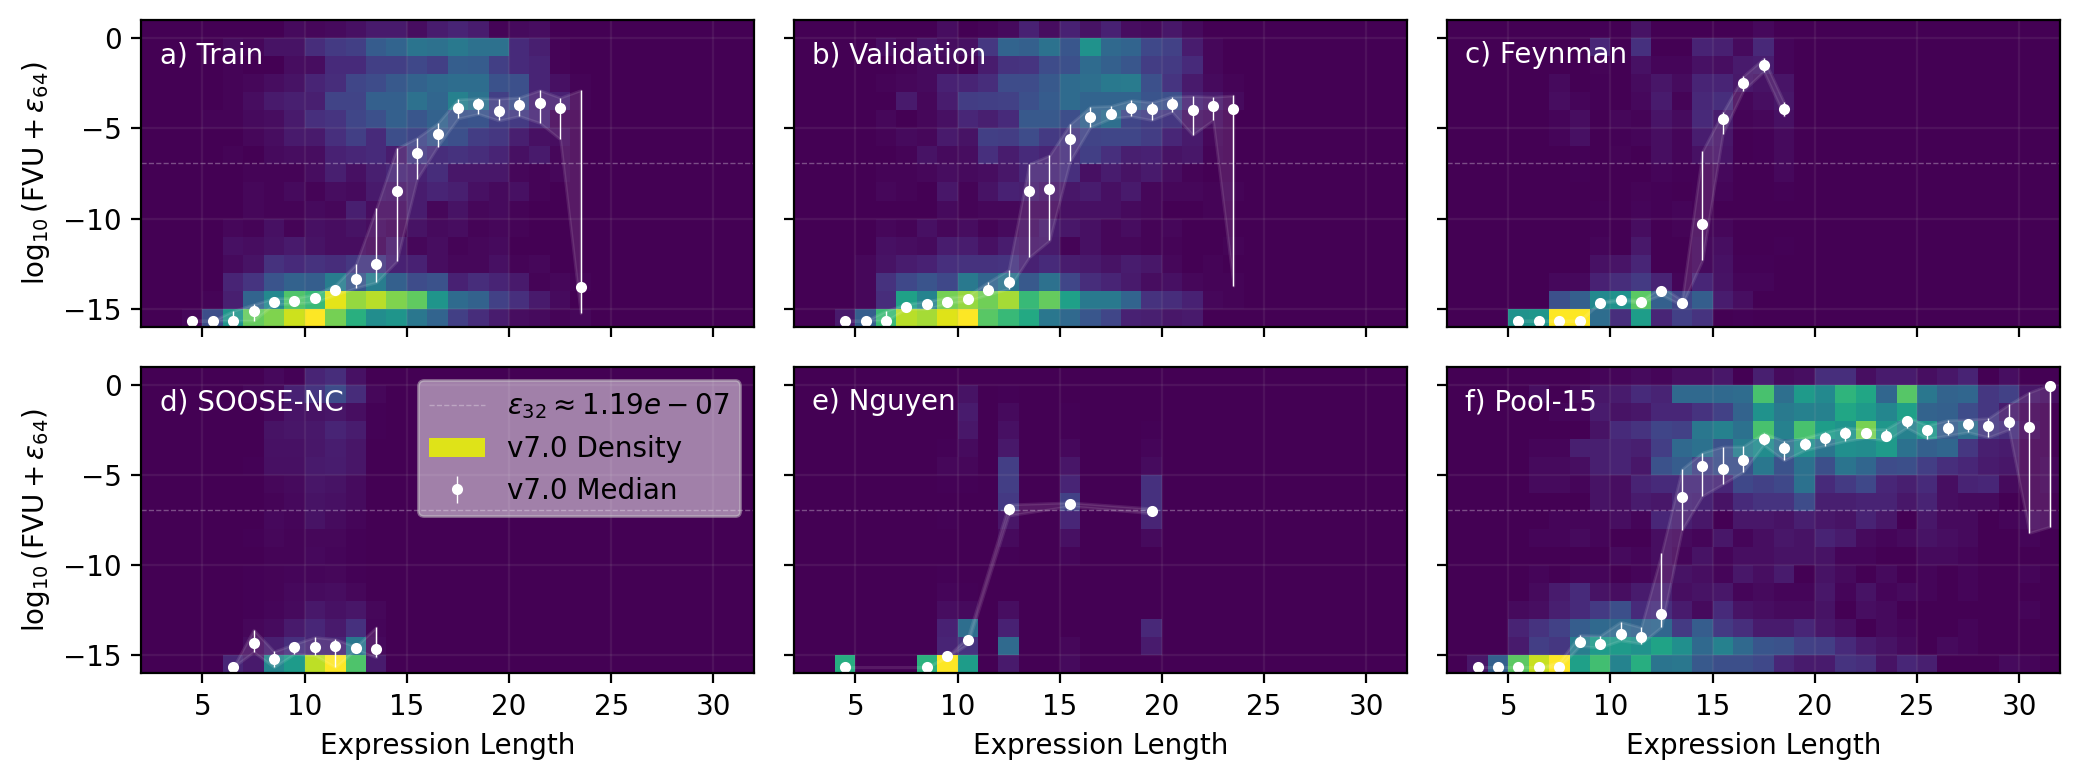

In [46]:
show_model = 'v7.0'
show_model_2 = 'v7.2'
metric = 'fvu'

COLS = 3
ROWS = 2

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 3.5, ROWS * 2), dpi=200, sharex=True, sharey=True)


for i, (ax, test_set) in enumerate(zip(axes.flatten(), TEST_SETS)):
    ax.hist2d(
        array_dfs[show_model][test_set]['length_target'],
        np.log10(array_dfs[show_model][test_set]['fvu'] + np.finfo(np.float64).eps),
        bins=(np.arange(2, 33), np.linspace(-16, 1, 18)),
        cmap='viridis',
        rasterized=True)

    # Draw the median FVU for each length
    bootstraps = [bootstrapped_metric_ci(data_lengths[show_model][test_set][length][metric].values + np.finfo(np.float64).eps, np.nanmedian, n=N_BOOTSTRAPS) for length in range(2, 32)]
    median = [b[0] for b in bootstraps]
    lower = [b[1] for b in bootstraps]
    upper = [b[2] for b in bootstraps]

    valid_mask = ~np.isnan(median)

    index = np.arange(2, 32)[valid_mask]
    median = np.array(median)[valid_mask]
    lower = np.array(lower)[valid_mask]
    upper = np.array(upper)[valid_mask]

    ax.errorbar(index + 0.5, np.log10(median), yerr=[np.log10(median) - np.log10(lower), np.log10(upper) - np.log10(median)], fmt='.', color='w', lw=0.5, label='v7.0 Median', zorder=2)
    ax.fill_between(index + 0.5, np.log10(lower), np.log10(upper), color='w', alpha=0.1, zorder=2)

    if show_model_2 in data_lengths and data_lengths[show_model_2][test_set] is not None:
        bootstraps = [bootstrapped_metric_ci(data_lengths[show_model_2][test_set][length][metric].values + np.finfo(np.float64).eps, np.nanmedian, n=N_BOOTSTRAPS) for length in range(2, 32)]
        median = [b[0] for b in bootstraps]
        lower = [b[1] for b in bootstraps]
        upper = [b[2] for b in bootstraps]

        valid_mask = ~np.isnan(median)

        index = np.arange(2, 32)[valid_mask]
        median = np.array(median)[valid_mask]
        lower = np.array(lower)[valid_mask]
        upper = np.array(upper)[valid_mask]

        ax.errorbar(index + 0.5, np.log10(median), yerr=[np.log10(median) - np.log10(lower), np.log10(upper) - np.log10(median)], fmt='s', color='tab:orange', lw=0.5, label=f'{show_model_2} Median', zorder=1, markersize=2)
        ax.fill_between(index + 0.5, np.log10(lower), np.log10(upper), color='tab:orange', alpha=0.1, zorder=1)

    ax.grid(zorder=0, alpha=0.1)
    ax.annotate(f'{chr(ord("a") + i)}) {TEST_SET_TITLES_LONG[test_set]}', xy=(0.03, 0.93), xycoords='axes fraction', ha='left', va='top', color='w')
    if i % COLS == 0:
        ax.set_ylabel('$\\log_{10}(\\text{FVU} + \\epsilon_{64})$')
    if i >= (ROWS - 1) * COLS:
        ax.set_xlabel('Expression Length')

    ax.axhline(np.log10(np.finfo(np.float32).eps), color='w', lw=0.5, ls='--', alpha=0.3, zorder=1, label='$\\epsilon_{32} \\approx' + f'{np.finfo(np.float32).eps:.2e}$')

fig.tight_layout()

# Add a handle for the histogram
l = plt.Rectangle((0, 0), 0.5, 1, fc=plt.get_cmap('viridis')(0.95))

handles, labels = axes[0, 1].get_legend_handles_labels()
handles.insert(1, l)
labels.insert(1, 'v7.0 Density')

axes[1, 0].legend(framealpha=0.5, handles=handles, labels=labels, loc='upper right')

if 'v7.2' in data_lengths:
    plt.savefig(get_path('results', 'main', create=True, filename='fvu_length_heatmaps_comparison.svg'), bbox_inches='tight')

In [47]:
model = 'v7.0'
test_set = 'pool_15'
for i in range(10):
    print(f"L = {len(results[model][test_set]['data']['input_ids'][i][1:-1])}")
    print(f"{results[model][test_set]['data']['fvu'][i]:.2e}")
    print(space.tokenizer.decode(results[model][test_set]['data']['free_beam_1'][i]))
    print(space.tokenizer.decode(results[model][test_set]['data']['input_ids'][i])[1:-1])
    print()

L = 21
2.29e-04
['-', '*', 'x2', '+', 'x3', 'tan', 'x1', 'x2']
['*', 'x2', '+', 'x3', '+', 'asin', 'x1', '+', '/', 'sin', 'abs', 'x1', 'x1', '*', '<num>', 'exp', '+', '<num>', '+', '<num>', 'x2']

L = 17
1.20e-05
['+', '/', '<num>', 'pow2', 'x3', '*', '<num>', '/', 'x1', '+', '<num>', 'tan', 'x2']
['/', '+', '<num>', '*', 'x3', 'abs', '/', 'x1', '+', '<num>', '-', 'tan', 'x3', 'sin', 'x2', 'pow2', 'x3']

L = 21
1.96e-02
['*', '<num>', '+', 'x1', '+', 'x1', '+', 'abs', 'x2', 'pow2', 'atan', '/', 'x3', 'x2']
['-', '*', '<num>', '+', '<num>', '+', '/', 'pow2', 'x1', 'x1', 'pow1_2', '*', 'x2', '+', 'x2', 'atan', '/', 'pow2', 'x3', 'x2', 'x2']

L = 29
8.18e-01
['/', '/', '+', '<num>', 'tan', 'pow2', 'x3', 'x1', 'x2']
['*', 'x2', '/', '+', 'cos', 'x2', 'tan', '*', '<num>', 'x3', 'pow1_2', '-', '*', 'x1', '+', '*', 'x2', 'x3', 'pow2', '*', 'x2', '+', '<num>', '+', '<num>', '+', 'x1', 'x1', 'x2']

L = 15
8.93e-05
['+', '<num>', '+', 'x3', '/', 'x3', '+', 'x1', 'x2']
['+', 'x3', '+', 'log', '*'

# Aggregated

In [48]:
sub_metrics = ['mean', 'median', '2.5p', '97.5p']
sub_metrics_functions = [naninfmean, np.nanmedian, partial(np.nanpercentile, q=2.5), partial(np.nanpercentile, q=97.5)]

total_summary = {model: {column: {k: (np.nan, ) * 3 for k in sub_metrics} for column in compare_columns} for model in array_dfs.keys()}
aggregate_sets = ['feynman', 'soose_nc', 'nguyen', 'pool_15']
metrics = None

N_BOOTSTRAPS = 1_000

for model, model_dfs in array_dfs.items():
    if len(model_dfs) == 0:
        continue
    aggregated_data = pd.concat([df for test_set, df in model_dfs.items() if test_set in aggregate_sets])

    for column in tqdm(compare_columns, desc=f'{model}'):
        if column in aggregated_data.columns:
            data = aggregated_data[column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
            total_summary[model][column] = {m: bootstrapped_metric_ci(data, f, n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}

    if metrics is None:
        metrics = total_summary[model][column].keys()

pysr:  16%|█▋        | 8/49 [00:01<00:09,  4.19it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
pysr:  33%|███▎      | 16/49 [00:03<00:07,  4.15it/s]/tmp/ipykernel_1874/3880369273.py:2: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.array(x)[np.isfinite(x)])
v9.1: 100%|██████████| 49/49 [01:01<00:00,  1.26s/it]


In [49]:
sub_metrics = ['mean', 'median', '2.5p', '97.5p']
sub_metrics_functions = [naninfmean, np.nanmedian, partial(np.nanpercentile, q=2.5), partial(np.nanpercentile, q=97.5)]

total_ar_p = {model: {column: {k: (np.nan, ) * 3 for k in sub_metrics} for column in compare_columns} for model in array_dfs.keys()}
aggregate_sets = ['feynman', 'soose_nc', 'nguyen', 'pool_15']

reference_model = 'v7.0'
reference_aggregated_data = pd.concat([df for test_set, df in array_dfs[reference_model].items() if test_set in aggregate_sets])

N_BOOTSTRAPS = 1_000

for model, model_dfs in array_dfs.items():
    if len(model_dfs) == 0:
        continue
    aggregated_data = pd.concat([df for test_set, df in model_dfs.items() if test_set in aggregate_sets])

    for column in tqdm(compare_columns, desc=f'{model}'):
        if column in aggregated_data.columns:
            data = aggregated_data[column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
            if column not in reference_aggregated_data.columns:
                total_ar_p[model][column] = {k: (np.nan, ) * 2 for k in sub_metrics}
            else:
                reference_data = reference_aggregated_data[column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
                
                total_ar_p[model][column] = {m: ar_test(reference_data, data, lambda x, y: f(x) - f(y), n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}

pysr:  16%|█▋        | 8/49 [00:11<01:01,  1.49s/it]/tmp/ipykernel_1874/2734215389.py:25: RuntimeWarning: invalid value encountered in scalar subtract
  total_ar_p[model][column] = {m: ar_test(reference_data, data, lambda x, y: f(x) - f(y), n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}
pysr:  33%|███▎      | 16/49 [00:24<00:50,  1.54s/it]/tmp/ipykernel_1874/3880369273.py:2: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.array(x)[np.isfinite(x)])
v9.1: 100%|██████████| 49/49 [01:46<00:00,  2.17s/it]


In [50]:
total_summary_tables = {
    metric: {
        percentile:
            pd.DataFrame({
            model: {
                column: total_summary[model][column][metric][k]
                for column in compare_columns}
                for model in total_summary.keys()}).T.round(3)
                for k, percentile in enumerate(['median', 'lower', 'upper'])}
                for metric in metrics}

In [51]:
total_ar_tables = {
    metric: {
        value:
            pd.DataFrame({
            model: {
                column: total_ar_p[model][column][metric][k]
                for column in compare_columns}
                for model in total_ar_p.keys()}).T.round(3)
                for k, value in enumerate(['statistic', 'p'])}
                for metric in metrics}

In [52]:
columns = [c for c in total_summary_tables['mean']['median'].T.index if 'accuracy' in c]
total_summary_tables['mean']['median'].T.loc[columns].sort_index().astype(str) + ' (' + total_summary_tables['mean']['lower'].T.loc[columns].sort_index().astype(str) + ', ' + total_summary_tables['mean']['upper'].T.loc[columns].sort_index().astype(str) + ')'

,pysr,nesymres-100M,v7.0,v7.0-mini,v7.11,v7.12,v7.20,v8.0,v9.0,v9.1
FVU-eps_accuracy,"0.611 (0.596, 0.625)","0.358 (0.343, 0.373)","0.645 (0.638, 0.652)","0.41 (0.404, 0.417)","0.616 (0.61, 0.624)","0.556 (0.549, 0.562)","0.644 (0.637, 0.651)","0.577 (0.57, 0.584)","0.658 (0.652, 0.665)","0.659 (0.652, 0.665)"
FVU-eps_accuracy_val,"0.602 (0.588, 0.618)","0.356 (0.341, 0.37)","0.643 (0.636, 0.65)","0.409 (0.402, 0.416)","0.614 (0.608, 0.622)","0.554 (0.547, 0.561)","0.642 (0.635, 0.648)","0.575 (0.568, 0.582)","0.657 (0.651, 0.664)","0.658 (0.652, 0.665)"
NSRTS_accuracy_close_best_beam,"0.79 (0.777, 0.803)","0.501 (0.487, 0.517)","0.808 (0.803, 0.813)","0.602 (0.596, 0.609)","0.796 (0.79, 0.801)","0.73 (0.723, 0.736)","0.796 (0.79, 0.801)","0.762 (0.756, 0.768)","0.793 (0.787, 0.798)","0.793 (0.788, 0.799)"
NSRTS_accuracy_close_val_best_beam,"0.789 (0.776, 0.802)","0.503 (0.486, 0.517)","0.806 (0.801, 0.812)","0.602 (0.595, 0.609)","0.796 (0.79, 0.802)","0.729 (0.724, 0.735)","0.796 (0.791, 0.802)","0.762 (0.756, 0.768)","0.793 (0.787, 0.799)","0.793 (0.787, 0.799)"
NSRTS_accuracy_r2_best_beam,"0.911 (0.902, 0.919)","0.654 (0.638, 0.668)","0.908 (0.904, 0.912)","0.77 (0.764, 0.776)","0.896 (0.892, 0.9)","0.865 (0.86, 0.87)","0.897 (0.893, 0.901)","0.88 (0.875, 0.884)","0.892 (0.888, 0.897)","0.886 (0.881, 0.89)"
NSRTS_accuracy_r2_val_best_beam,"0.874 (0.864, 0.884)","0.637 (0.622, 0.652)","0.899 (0.895, 0.903)","0.756 (0.75, 0.763)","0.886 (0.881, 0.89)","0.856 (0.851, 0.861)","0.888 (0.884, 0.892)","0.869 (0.864, 0.874)","0.883 (0.879, 0.888)","0.877 (0.872, 0.882)"
accuracy_best_beam,"0.002 (0.001, 0.004)","0.07 (0.062, 0.078)","0.262 (0.256, 0.267)","0.156 (0.151, 0.162)","0.254 (0.248, 0.26)","0.283 (0.277, 0.29)","0.223 (0.218, 0.229)","0.198 (0.193, 0.204)","0.379 (0.373, 0.386)","0.395 (0.388, 0.402)"
structural_accuracy_best_beam,"0.935 (0.928, 0.943)","0.001 (0.0, 0.002)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"


In [53]:
columns = [c for c in total_summary_tables['mean']['median'].T.index if 'accuracy' in c]
total_ar_tables['mean']['p'].T.loc[columns].sort_index()

,pysr,nesymres-100M,v7.0,v7.0-mini,v7.11,v7.12,v7.20,v8.0,v9.0,v9.1
FVU-eps_accuracy,0.000,0.0,1.0,0.0,0.000,0.000,0.834,0.000,0.004,0.002
FVU-eps_accuracy_val,0.000,0.0,1.0,0.0,0.000,0.000,0.827,0.000,0.005,0.004
NSRTS_accuracy_close_best_beam,0.005,0.0,1.0,0.0,0.002,0.000,0.001,0.000,0.000,0.001
NSRTS_accuracy_close_val_best_beam,0.011,0.0,1.0,0.0,0.018,0.000,0.011,0.000,0.000,0.001
NSRTS_accuracy_r2_best_beam,0.563,0.0,1.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000
NSRTS_accuracy_r2_val_best_beam,0.000,0.0,1.0,0.0,0.000,0.000,0.001,0.000,0.000,0.000
accuracy_best_beam,0.000,0.0,1.0,0.0,0.096,0.000,0.000,0.000,0.000,0.000
structural_accuracy_best_beam,0.000,0.0,1.0,1.0,1.000,0.624,1.000,0.257,0.635,0.267


In [54]:
columns = ['edit_distance_best_beam', 'tree_edit_distance_best_beam', 'f1_score_best_beam', 'meteor_best_beam', 'precision_best_beam', 'bleu_best_beam', 'recall_best_beam', 'rougeL_recall_best_beam', 'reciprocal_rank', 'perplexity', 'log_ppl', 'fvu', 'log_fvu',  'sys_time', 'wall_time']
total_summary_tables['mean']['median'].T.loc[columns].astype(str) + ' (' + total_summary_tables['mean']['lower'].T.loc[columns].astype(str) + ', ' + total_summary_tables['mean']['upper'].T.loc[columns].astype(str) + ')'

,pysr,nesymres-100M,v7.0,v7.0-mini,v7.11,v7.12,v7.20,v8.0,v9.0,v9.1
edit_distance_best_beam,"11.418 (11.229, 11.618)","8.562 (8.414, 8.704)","4.981 (4.921, 5.049)","6.048 (5.989, 6.106)","6.928 (6.849, 7.005)","4.977 (4.915, 5.047)","5.084 (5.028, 5.143)","5.421 (5.357, 5.483)","4.528 (4.463, 4.592)","4.455 (4.385, 4.52)"
tree_edit_distance_best_beam,"29.929 (29.322, 30.495)","23.607 (23.173, 24.021)","13.271 (13.112, 13.439)","16.134 (15.96, 16.285)","18.334 (18.124, 18.541)","13.029 (12.874, 13.204)","13.651 (13.483, 13.805)","14.572 (14.402, 14.719)","12.285 (12.096, 12.456)","12.123 (11.935, 12.296)"
f1_score_best_beam,"0.677 (0.672, 0.682)","0.71 (0.703, 0.717)","0.879 (0.877, 0.881)","0.804 (0.801, 0.806)","0.861 (0.859, 0.863)","0.854 (0.852, 0.857)","0.856 (0.854, 0.857)","0.84 (0.838, 0.842)","0.875 (0.873, 0.877)","0.876 (0.874, 0.878)"
meteor_best_beam,"0.365 (0.36, 0.37)","0.46 (0.452, 0.468)","0.67 (0.666, 0.675)","0.553 (0.55, 0.557)","0.646 (0.642, 0.65)","0.64 (0.636, 0.644)","0.648 (0.644, 0.652)","0.631 (0.627, 0.635)","0.707 (0.703, 0.711)","0.71 (0.706, 0.714)"
precision_best_beam,"0.746 (0.739, 0.753)","0.703 (0.695, 0.71)","0.896 (0.894, 0.898)","0.84 (0.837, 0.842)","0.878 (0.876, 0.88)","0.882 (0.881, 0.884)","0.872 (0.87, 0.874)","0.863 (0.861, 0.865)","0.904 (0.902, 0.906)","0.904 (0.902, 0.906)"
bleu_best_beam,"0.094 (0.09, 0.099)","0.165 (0.158, 0.173)","0.44 (0.435, 0.445)","0.304 (0.299, 0.309)","0.396 (0.391, 0.402)","0.43 (0.425, 0.436)","0.395 (0.39, 0.4)","0.38 (0.375, 0.385)","0.501 (0.495, 0.507)","0.513 (0.507, 0.518)"
recall_best_beam,"0.644 (0.638, 0.648)","0.747 (0.739, 0.755)","0.872 (0.87, 0.874)","0.788 (0.785, 0.79)","0.856 (0.853, 0.858)","0.84 (0.838, 0.843)","0.853 (0.851, 0.855)","0.833 (0.83, 0.835)","0.857 (0.855, 0.86)","0.859 (0.856, 0.861)"
rougeL_recall_best_beam,"0.405 (0.399, 0.411)","0.471 (0.464, 0.478)","0.719 (0.716, 0.722)","0.644 (0.641, 0.647)","0.637 (0.634, 0.64)","0.745 (0.742, 0.748)","0.711 (0.708, 0.713)","0.687 (0.684, 0.689)","0.749 (0.746, 0.752)","0.757 (0.753, 0.76)"
reciprocal_rank,"nan (nan, nan)","nan (nan, nan)","0.83 (0.828, 0.832)","0.758 (0.756, 0.76)","0.816 (0.814, 0.818)","0.819 (0.816, 0.821)","0.797 (0.795, 0.799)","0.798 (0.796, 0.8)","0.864 (0.862, 0.865)","0.861 (0.859, 0.863)"
perplexity,"nan (nan, nan)","nan (nan, nan)","116886.355 (18359.839, 294610.652)","1374.075 (1044.575, 1827.28)","19.017 (15.282, 25.368)","5581.866 (4160.504, 7286.681)","7471.885 (6410.744, 8958.116)","42250.822 (29347.602, 56832.993)","442499.07 (350605.212, 552192.487)","145741354.116 (117945475.155, 176838919.413)"


In [55]:
columns = ['edit_distance_best_beam', 'tree_edit_distance_best_beam', 'f1_score_best_beam', 'meteor_best_beam', 'precision_best_beam', 'bleu_best_beam', 'recall_best_beam', 'rougeL_recall_best_beam', 'reciprocal_rank', 'perplexity', 'log_ppl', 'fvu', 'log_fvu',  'sys_time', 'wall_time']
total_ar_tables['mean']['p'].T.loc[columns]

,pysr,nesymres-100M,v7.0,v7.0-mini,v7.11,v7.12,v7.20,v8.0,v9.0,v9.1
edit_distance_best_beam,0.000,0.0,1.0,0.00,0.0,0.941,0.020,0.000,0.000,0.000
tree_edit_distance_best_beam,0.000,0.0,1.0,0.00,0.0,0.037,0.001,0.000,0.000,0.000
f1_score_best_beam,0.000,0.0,1.0,0.00,0.0,0.000,0.000,0.000,0.006,0.030
meteor_best_beam,0.000,0.0,1.0,0.00,0.0,0.000,0.000,0.000,0.000,0.000
precision_best_beam,0.000,0.0,1.0,0.00,0.0,0.000,0.000,0.000,0.000,0.000
bleu_best_beam,0.000,0.0,1.0,0.00,0.0,0.014,0.000,0.000,0.000,0.000
recall_best_beam,0.000,0.0,1.0,0.00,0.0,0.000,0.000,0.000,0.000,0.000
rougeL_recall_best_beam,0.000,0.0,1.0,0.00,0.0,0.000,0.001,0.000,0.000,0.000
reciprocal_rank,NaN,NaN,1.0,0.00,0.0,0.000,0.000,0.000,0.000,0.000
perplexity,NaN,NaN,1.0,0.00,0.0,0.000,0.000,0.466,0.000,0.000


## Complete Metrics

In [56]:
def summary_table_to_typst(summary_tables, ar_tables, metrics, metric_submetrics, default_submetric, caption,
                           tag, objectives=None, font_size=9, ci_font_size=6, fmt_fn=None, metric_factors=None,
                           metric_aliases=None, hline_after=None):
    if fmt_fn is None:
        fmt_fn = lambda x: f'{x:.2f}'

    if objectives is None:
        objectives = {m: 'max' for m in metrics}

    if metric_factors is None:
        metric_factors = {m: 1 for m in metrics}

    if metric_aliases is None:
        metric_aliases = {m: m.replace('_', ' ').replace(' best beam', '') for m in metrics}

    main_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['median'].T.loc[m] for m in metrics}).T
    lower_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['lower'].T.loc[m] for m in metrics}).T
    upper_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['upper'].T.loc[m] for m in metrics}).T
    ar_df = pd.DataFrame({m: ar_tables[metric_submetrics.get(m, default_submetric)]['p'].T.loc[m] for m in metrics}).T
    # Determine the best model for each test set

    best_model = {m: main_df.loc[m].idxmax() if objectives[m] == 'max' else main_df.loc[m].idxmin() for m in metrics}
    equal_mask = pd.concat([upper_df.loc[m] >= lower_df.loc[m, best_model[m]] if objectives[m] == 'max' else lower_df.loc[m] <= upper_df.loc[m, best_model[m]] for m in metrics], axis=1).T


    output = f'''
#figure(
    [
        #show <table_CI>: set text({ci_font_size}pt)
        #text(
        size:{font_size}pt,
        table(
        stroke: (x, y) => if x == 0 or x == 3 {{
            (right: (
            thickness: 0.5pt,
            ))
            }},
        inset: 6.5pt,
        columns: ({', '.join(['auto' for _ in range(main_df.shape[1] + 1)])}),
        align: center + horizon,
        table.hline(),
    '''
    
    output += f"  [*Metric*], "
    for model in main_df.columns:
        flash = '#emoji.lightning$thin$' if model.startswith('v') else ''
        output += f"[*{flash + model}*], "
    output += "\n  table.hline(stroke: 0.5pt),\n"
    
    for main_row, lower_row, upper_row, equal_best_row, ar_row in zip(main_df.iterrows(), lower_df.iterrows(), upper_df.iterrows(), equal_mask.iterrows(), ar_df.iterrows()):
        factor = metric_factors.get(main_row[0], 1)
        alias = metric_aliases.get(main_row[0], main_row[0])
        output += f"  [{alias}], \n"
        output += ", ".join([
            '['
                + ("*" if equal_best_row[1].get(m, False) else '')
                + f"${fmt_fn(main_row[1].get(m, np.nan) * factor)}$\ #[(${fmt_fn(lower_row[1].get(m, np.nan) * factor)}$, ${fmt_fn(upper_row[1].get(m, np.nan) * factor)}$)] <table_CI>"
                + ("*" if equal_best_row[1].get(m, False) else '')
                + "\\ "
                + ("#underline[" if ar_row[1].get(m, np.nan) >= 0.05 else "")
                +  f"#[p = {fmt_fn(ar_row[1].get(m, np.nan))}] <table_CI>"
                + ("]" if ar_row[1].get(m, np.nan) >= 0.05 else "")
            + ']'
            for m in main_row[1].keys()
        ]) + ",\n"
        if hline_after is not None and main_row[0] in hline_after:
            output += f'  table.hline(stroke: (thickness:0.5pt, dash:"dotted")),\n'

    output = output.replace('$---$', '---').replace('nesymres-100M', 'N100').replace('pysr', 'PySR')

    output += f'''
    table.hline(),
    ))],
    caption: [{caption}],
    gap: 1.2em,
) <{tag}>
'''

    return output

In [57]:
columns = ['is_finite', 'FVU-eps_accuracy', 'FVU-eps_accuracy_val', 'NSRTS_accuracy_close_best_beam', 'NSRTS_accuracy_r2_best_beam', 'accuracy_best_beam']
columns += ['log_fvu_not_epsilon',  'log_fvu_not_epsilon_val', 'edit_distance_best_beam', 'tree_edit_distance_best_beam', 'meteor_best_beam', 'f1_score_best_beam', 'precision_best_beam', 'recall_best_beam', 'reciprocal_rank', 'perplexity', 'wall_time']

metric_aliases = {
    "FVU-eps_accuracy": '$"%"_("FVU" <= space epsilon) attach(arrow.t, tr:[0, 100])$ \ #[Numeric Recovery Rate (Fit)] <table_CI>',
    "FVU-eps_accuracy_val": '$"%"_("FVU" <= space epsilon) attach(arrow.t, tr:[0, 100])$ \ #[Numeric Recovery Rate (Val)] <table_CI>',
    "NSRTS_accuracy_close_best_beam": '$"%"_(hat(f)(X) approx Y) attach(arrow.t, tr:[0, 100])$ \ #[NeSymReS $A^("iid")_1$] <table_CI>',
    "NSRTS_accuracy_r2_best_beam": '$"%"_(R^2 space > space 0.95) attach(arrow.t, tr:[0, 100])$ \ #[NeSymReS $A^("iid")_2$] <table_CI>',
    "accuracy_best_beam": '$%_(hat(Z) = Z) attach(arrow.t, tr:[0, 100])$ \ Symbolic Recovery Rate <table_CI>',
    "is_finite": '$"%"_("valid") attach(arrow.t, tr:[0, 100])$',
    "edit_distance_best_beam": 'LEV $attach(arrow.b, tr:[0, oo])$ \ Levenshtein Distance<table_CI>',
    "tree_edit_distance_best_beam":	'ZSS $attach(arrow.b, tr:[0, oo])$ \ Tree-Edit Distance<table_CI>',
    "f1_score_best_beam": 'F1 $attach(arrow.t, tr:[0, 1])$',
    "meteor_best_beam":	'METEOR $attach(arrow.t, tr:[0, 1])$',
    "precision_best_beam":	'Precision $attach(arrow.t, tr:[0, 1])$',
    "bleu_best_beam": 'BLEU $attach(arrow.t, tr:[0, 1])$',
    "recall_best_beam":	'Recall $attach(arrow.t, tr:[0, 1])$',
    "rougeL_recall_best_beam": 'Rouge-L Recall $attach(arrow.t, tr:[0, 1])$',
    "reciprocal_rank": 'RR $attach(arrow.t, tr:[0, 1])$ \ Reciprocal Rank<table_CI>',
    "perplexity": 'PPL $attach(arrow.b, tr:[1, oo])$ \ Perplexity<table_CI>',
    "log_ppl": 'log PPL $attach(arrow.b, tr:[0, oo])$',
    "fvu": 'FVU $attach(arrow.b, tr:[0, oo])$ \ Unexplained Variance<table_CI>',
    "log_fvu": f'$log_(10) "FVU" attach(arrow.b, tr:[{np.log10(np.finfo(np.float32).eps):.2f}, oo])$',
    'log_fvu_not_epsilon': f'$log_(10) "FVU"_(> epsilon) attach(arrow.b, tr:[{np.log10(np.finfo(np.float32).eps):.2f}, oo])$ \ #[Approximation Error (Fit)]<table_CI>',
    "log_fvu_not_epsilon_val": f'$log_(10) "FVU"_(> epsilon) attach(arrow.b, tr:[{np.log10(np.finfo(np.float32).eps):.2f}, oo])$ \ #[Approximation Error (Val)]<table_CI>',
    "sys_time": 'T#sub("sys") $attach(arrow.b, tr:[0, oo])$ \ System Time<table_CI>',
    "wall_time": 'T#sub("wall") $attach(arrow.b, tr:[0, oo])$ \ Wall Time<table_CI>',
}

metric_objectives = {
    "FVU-eps_accuracy": 'max',
    "FVU-eps_accuracy_val": 'max',
    "NSRTS_accuracy_close_best_beam": 'max',
    "NSRTS_accuracy_r2_best_beam": 'max',
    "accuracy_best_beam": 'max',
    "is_finite": 'max',
    "edit_distance_best_beam":	'min',
    "tree_edit_distance_best_beam":	'min',
    "f1_score_best_beam": 'max',
    "meteor_best_beam":	'max',
    "precision_best_beam":	'max',
    "bleu_best_beam": 'max',
    "recall_best_beam":	'max',
    "rougeL_recall_best_beam": 'max',
    "reciprocal_rank": 'max',
    "perplexity": 'min',
    "log_ppl": 'min',
    "fvu": 'min',
    "log_fvu": 'min',
    'log_fvu_not_epsilon': 'min',
    'log_fvu_not_epsilon_val': 'min',
    "sys_time": 'min',
    "wall_time": 'min',
}

metric_factors = {
    "FVU-eps_accuracy": 100,
    "FVU-eps_accuracy_val": 100,
    "NSRTS_accuracy_close_best_beam": 100,
    "NSRTS_accuracy_r2_best_beam": 100,
    "accuracy_best_beam": 100,
    "is_finite": 100,
}

metric_submetrics = {
    "FVU-eps_accuracy": 'mean',
    "NSRTS_accuracy_close_best_beam": 'mean',
    "NSRTS_accuracy_r2_best_beam": 'mean',
    "accuracy_best_beam": 'mean',
    "perplexity": 'median',
}


print(summary_table_to_typst(
    total_summary_tables,
    total_ar_tables,
    columns,
    metric_submetrics=metric_submetrics,
    default_submetric='mean',
    caption='*Detailed Model Comparison and Ablation Study.* Bootstrapped 95% CI.\ Values represent mean (PPL: median) over all test sets.',
    tag='tab:ablation_study_all',
    objectives=metric_objectives,
    fmt_fn=fmt_fn_100,
    metric_aliases=metric_aliases,
    metric_factors=metric_factors,
    hline_after=['is_finite', 'accuracy_best_beam', 'log_fvu', 'perplexity', 'log_fvu_not_epsilon_val'],
    font_size=6,
    ci_font_size=3
))


#figure(
    [
        #show <table_CI>: set text(3pt)
        #text(
        size:6pt,
        table(
        stroke: (x, y) => if x == 0 or x == 3 {
            (right: (
            thickness: 0.5pt,
            ))
            },
        inset: 6.5pt,
        columns: (auto, auto, auto, auto, auto, auto, auto, auto, auto, auto, auto),
        align: center + horizon,
        table.hline(),
      [*Metric*], [*PySR*], [*N100*], [*#emoji.lightning$thin$v7.0*], [*#emoji.lightning$thin$v7.0-mini*], [*#emoji.lightning$thin$v7.11*], [*#emoji.lightning$thin$v7.12*], [*#emoji.lightning$thin$v7.20*], [*#emoji.lightning$thin$v8.0*], [*#emoji.lightning$thin$v9.0*], [*#emoji.lightning$thin$v9.1*], 
  table.hline(stroke: 0.5pt),
  [$"%"_("valid") attach(arrow.t, tr:[0, 100])$], 
[*$100$\ #[($100$, $100$)] <table_CI>*\ #underline[#[p = 1.00] <table_CI>]], [$94.1$\ #[($93.3$, $94.8$)] <table_CI>\ #[p = 0.00] <table_CI>], [*$100$\ #[($100$, $100$)] <table_CI>*\ #underline[#[p = 1.00] <table_CI>]],

## Showcase

In [58]:
def summary_table_to_typst_T(summary_tables, ar_tables, metrics, metric_submetrics, default_submetric, caption,
                           tag, objectives=None, font_size=9, ci_font_size=5, fmt_fn=None, metric_factors=None,
                           metric_aliases=None, model_aliases=None, hline_after=None, join_cells_list=[]):
    if fmt_fn is None:
        fmt_fn = lambda x: f'{x:.2f}'

    if objectives is None:
        objectives = {m: 'max' for m in metrics}

    if metric_factors is None:
        metric_factors = {m: 1 for m in metrics}

    if metric_aliases is None:
        metric_aliases = {m: m.replace('_', ' ').replace(' best beam', '') for m in metrics}

    if model_aliases is None:
        model_aliases = {m: m for m in summary_tables[metrics[0]]['mean']['median'].columns}

    main_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['median'].T.loc[m] for m in metrics}).T
    lower_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['lower'].T.loc[m] for m in metrics}).T
    upper_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['upper'].T.loc[m] for m in metrics}).T
    ar_df = pd.DataFrame({m: ar_tables[metric_submetrics.get(m, default_submetric)]['p'].T.loc[m] for m in metrics}).T
    # Determine the best model for each test set
    best_model = {m: main_df.loc[m].idxmax() if objectives[m] == 'max' else main_df.loc[m].idxmin() for m in metrics}
    equal_mask = pd.concat([upper_df.loc[m] >= lower_df.loc[m, best_model[m]] if objectives[m] == 'max' else lower_df.loc[m] <= upper_df.loc[m, best_model[m]] for m in metrics], axis=1).T

    output = f'''
#figure(
    [
        #show <table_CI>: set text({ci_font_size}pt)
        #show <ablation>: set text(7pt)
        #text(
        size:{font_size}pt,
        table(
        stroke: (x, y) => if x == 0 {{
            (right: (
            thickness: 0.5pt,
            ))
          }} else if (x == 2 or x == 4) {{
            (right: (
            thickness: 0.5pt,
            dash:"dotted"
            ))
          }} else if y == 0 and (x == 1 or x == 3) {{
            (right: (
            thickness: 0.5pt,
            dash:"dotted"
            ))
          }},
        fill: (_, y) => if calc.odd(y + 1) and y > 1 {{ luma(table_gray) }} else {{ white }},
        inset: 6.5pt,
        columns: ({', '.join(['auto' for _ in range(main_df.shape[0] + 1)])}),
        align: center + horizon,
        table.hline(),
    '''
    
    output += f"  [*Model*], "
    for main_row in main_df.iterrows():
        alias = metric_aliases.get(main_row[0], main_row[0])
        output += f" [*{alias}*],"
    output += "\n[-], [Fit], [Val], [Fit], [Val], [-], [-], [-],"
    output += "\n  table.hline(stroke: 0.5pt),\n"

    for join_cells, join_to in join_cells_list:
        output = output.replace(', '.join([f'[*{metric_aliases.get(m, m)}*]' for m in join_cells]), f'table.cell(colspan: {len(join_cells)}, [*{metric_aliases.get(join_to, join_to)}*])')
    
    for main_row, lower_row, upper_row, equal_best_row, ar_row in zip(main_df.T.iterrows(), lower_df.T.iterrows(), upper_df.T.iterrows(), equal_mask.T.iterrows(), ar_df.T.iterrows()):        
        output += f"  [{model_aliases.get(main_row[0], main_row[0])}], "
    
        output += ", ".join([
            '['
                + ("*" if equal_best_row[1].get(m, False) else '')
                + f"${fmt_fn(main_row[1].get(m, np.nan) * metric_factors.get(m, 1))}$\ #[(${fmt_fn(lower_row[1].get(m, np.nan) * metric_factors.get(m, 1))}$, ${fmt_fn(upper_row[1].get(m, np.nan) * metric_factors.get(m, 1))}$)] <table_CI>"
                + ("*" if equal_best_row[1].get(m, False) else '')
                + "\\ "
                + ("#underline[" if ar_row[1].get(m, np.nan) >= 0.05 else "")
                +  f"#[p = {fmt_fn(ar_row[1].get(m, np.nan))}] <table_CI>"
                + ("]" if ar_row[1].get(m, np.nan) >= 0.05 else "")
            + ']'
            for m in main_row[1].keys()
        ]) + ",\n"
        if hline_after is not None and main_row[0] in hline_after:
            output += f'  table.hline(stroke: (thickness:0.5pt)),\n'

    output = output.replace('$---$', '---')

    output += f'''
    table.hline(),
    ))],
    caption: [{caption}],
    gap: 1.2em,
) <{tag}>
'''

    return output

In [59]:
total_summary_tables['mean']['median']['accuracy_best_beam'].keys()

Index(['pysr', 'nesymres-100M', 'v7.0', 'v7.0-mini', 'v7.11', 'v7.12', 'v7.20',
       'v8.0', 'v9.0', 'v9.1'],
      dtype='object')

In [60]:
total_summary_tables['mean']['median']

,rouge1_fmeasure_best_beam,best_beam,fvu_val,rouge2_recall_best_beam,NSRTS_accuracy_r2_best_beam,wall_time,FVU-eps_accuracy,f1_score_best_beam,fvu_not_epsilon,sys_time,...,bleu_best_beam,recall_best_beam,NSRTS_accuracy_close_best_beam,length_target,r2_val_best_beam,rougeL_precision_best_beam,beam_search_time,edit_distance_best_beam,rougeL_fmeasure_best_beam,structural_accuracy_best_beam
pysr,0.530,1.000,3.460275e+33,0.174,0.911,3.995,0.611,0.677,1.520000e-01,127.834,...,0.094,0.644,0.790,12.263,-3.460275e+33,0.542,NaN,11.418,0.441,0.935
nesymres-100M,0.598,1.000,2.159284e+12,0.260,0.654,85.948,0.358,0.710,3.742644e+12,85.927,...,0.165,0.747,0.501,1.000,-2.156419e+12,0.583,NaN,8.562,0.503,0.001
v7.0,0.790,13.927,6.195605e+76,0.546,0.908,1.032,0.645,0.879,1.970000e-01,1.032,...,0.440,0.872,0.808,12.172,-6.195605e+76,0.730,0.939,4.981,0.713,1.000
v7.0-mini,0.714,1.052,9.964709e+35,0.426,0.770,0.402,0.410,0.804,4.082962e+297,0.402,...,0.304,0.788,0.602,12.210,-9.964709e+35,0.636,NaN,6.048,0.626,1.000
v7.11,0.742,13.925,2.902799e+22,0.502,0.896,1.166,0.616,0.861,4.190000e-01,1.166,...,0.396,0.856,0.796,12.147,-2.902799e+22,0.740,0.964,6.928,0.670,1.000
v7.12,0.779,5.847,1.733168e+66,0.554,0.865,0.712,0.556,0.854,2.180480e+13,0.712,...,0.430,0.840,0.730,12.203,-1.733255e+66,0.688,NaN,4.977,0.702,1.000
v7.20,0.787,6.520,1.264036e+10,0.515,0.897,0.762,0.644,0.856,2.490000e-01,0.762,...,0.395,0.853,0.796,12.196,-1.263973e+10,0.712,NaN,5.084,0.701,1.000
v8.0,0.763,6.235,1.997573e+32,0.494,0.880,0.666,0.577,0.840,4.121420e+05,0.666,...,0.380,0.833,0.762,12.242,-1.997573e+32,0.700,NaN,5.421,0.681,1.000
v9.0,0.830,1.054,1.813945e+93,0.607,0.892,0.553,0.658,0.875,2.315712e+05,0.552,...,0.501,0.857,0.793,14.181,-1.813945e+93,0.750,NaN,4.528,0.748,1.000
v9.1,0.831,4.047,1.322452e+16,0.617,0.886,0.517,0.659,0.876,9.884005e+03,0.517,...,0.513,0.859,0.793,14.185,-1.322452e+16,0.751,NaN,4.455,0.753,1.000


In [61]:
# show_models = ['pysr', 'nesymres-100M', 'v7.0']
show_models = MODELS

show_total_summary_tables = {}
for m in total_summary_tables.keys():
    show_total_summary_tables[m] = {}
    for sm in total_summary_tables[m].keys():
        # Filter the df to only keep rows where the index is in show_models
        show_total_summary_tables[m][sm] = total_summary_tables[m][sm].loc[show_models]

show_total_ar_tables = {}
for m in total_ar_tables.keys():
    show_total_ar_tables[m] = {}
    for sm in total_ar_tables[m].keys():
        # Filter the df to only keep rows where the index is in show_models
        show_total_ar_tables[m][sm] = total_ar_tables[m][sm].loc[show_models]

In [62]:
showcase_columns = ['FVU-eps_accuracy', 'FVU-eps_accuracy_val', 'log_fvu_not_epsilon',  'log_fvu_not_epsilon_val', 'tree_edit_distance_best_beam', 'perplexity', 'wall_time']

metric_aliases = {
    "FVU-eps_accuracy": '$"%"_("FVU" <= space epsilon)$\\ $attach(arrow.t, tr:[0, 100])$',
    "FVU-eps_accuracy_val": '$"%"_("FVU" <= space epsilon)$\\ $attach(arrow.t, tr:[0, 100])$',
    "tree_edit_distance_best_beam":	'ZSS\\ $attach(arrow.b, tr:[0, oo])$',
    "perplexity": 'PPL\\ $attach(arrow.b, tr:[1, oo])$',
    "log_fvu_not_epsilon": f'log $"FVU"_(> epsilon)$\\ $attach(arrow.b, tr:[{np.log10(np.finfo(np.float32).eps):.2f}, oo])$',
    "log_fvu_not_epsilon_val": f'log $"FVU"_(> epsilon)$\\ $attach(arrow.b, tr:[{np.log10(np.finfo(np.float32).eps):.2f}, oo])$',
    "wall_time": 'T#sub("wall") [s]\\ $attach(arrow.b, tr:[0, oo])$',
}

model_aliases = {
    'pysr': 'PySR',
    'nesymres-100M': 'NeSymReS\ 100M',
    'v7.0': '#emoji.lightning$thin$v7.0',
    'v7.1': '#emoji.lightning$thin$v7.1 \ no simplify <ablation>',
    'v7.2': '#emoji.lightning$thin$v7.2 \ $N_"ops" <= 5$ <ablation>',
    'v7.3': '#emoji.lightning$thin$v7.3 \ $S = 10$ <ablation>',
    'v7.4': '#emoji.lightning$thin$v7.4 \ $c ~ cal(U)(1, 5)$ <ablation>',
    'v7.5': '#emoji.lightning$thin$v7.5 \ no EPBS <ablation>',
    'v7.6': '#emoji.lightning$thin$v7.6 \ $N_"ops" ~ cal(U)(0, 5)$ <ablation>',
    'v7.7': '#emoji.lightning$thin$v7.7 \ BFGS <ablation>',
    
    'v7.0-mini': '#emoji.lightning$thin$v7.0-mini \ 2.7M Parameters <ablation>',
    'v7.11': '#emoji.lightning$thin$v7.11 \ $N_"ops" <= 15$ <ablation>',
    'v7.12': '#emoji.lightning$thin$v7.12 \ D <= 11 <ablation>',
    'v7.20': '#emoji.lightning$thin$v7.20 \ Auto Flash Simplify <ablation>',
    'v8.0': '#emoji.lightning$thin$v8.0 \ + $cal(L)_"CE"$ <ablation>',
    'v9.0': '#emoji.lightning$thin$v9.0 \ 50% complexity control <ablation>',
    'v9.1': '#emoji.lightning$thin$v9.1 \ 100% complexity control <ablation>',
}

metric_objectives = {
    "FVU-eps_accuracy": 'max',
    "FVU-eps_accuracy_val": 'max',
    "tree_edit_distance_best_beam":	'min',
    "perplexity": 'min',
    "log_fvu_not_epsilon": 'min',
    "log_fvu_not_epsilon_val": 'min',
    "wall_time": 'min',
}

metric_factors = {
    "FVU-eps_accuracy": 100,
    "FVU-eps_accuracy_val": 100,
}

metric_submetrics = {
    "FVU-eps_accuracy": 'mean',
    "FVU-eps_accuracy_val": 'mean',
    "NSRTS_accuracy_close_best_beam": 'mean',
    "NSRTS_accuracy_r2_best_beam": 'mean',
    "accuracy_best_beam": 'mean',
    "perplexity": 'median',
}

join_cells_list = [
    (['FVU-eps_accuracy', 'FVU-eps_accuracy_val'], 'FVU-eps_accuracy'),
    (['log_fvu_not_epsilon', 'log_fvu_not_epsilon_val'], 'log_fvu_not_epsilon'),
]

print(summary_table_to_typst_T(
    show_total_summary_tables,
    show_total_ar_tables,
    showcase_columns,
    metric_submetrics=metric_submetrics,
    default_submetric='mean',
    caption='*Model Comparison and Ablation Study.* Bootstrapped 95% CI.\ Values represent mean (PPL: median) over all test sets.',
    tag='tab:ablation_study',
    objectives=metric_objectives,
    fmt_fn=fmt_fn_100,
    font_size=8.6,
    metric_aliases=metric_aliases,
    model_aliases=model_aliases,
    metric_factors=metric_factors,
    hline_after=['v7.0'],
    join_cells_list=join_cells_list,
))


#figure(
    [
        #show <table_CI>: set text(5pt)
        #show <ablation>: set text(7pt)
        #text(
        size:8.6pt,
        table(
        stroke: (x, y) => if x == 0 {
            (right: (
            thickness: 0.5pt,
            ))
          } else if (x == 2 or x == 4) {
            (right: (
            thickness: 0.5pt,
            dash:"dotted"
            ))
          } else if y == 0 and (x == 1 or x == 3) {
            (right: (
            thickness: 0.5pt,
            dash:"dotted"
            ))
          },
        fill: (_, y) => if calc.odd(y + 1) and y > 1 { luma(table_gray) } else { white },
        inset: 6.5pt,
        columns: (auto, auto, auto, auto, auto, auto, auto, auto),
        align: center + horizon,
        table.hline(),
      [*Model*],  table.cell(colspan: 2, [*$"%"_("FVU" <= space epsilon)$\ $attach(arrow.t, tr:[0, 100])$*]), table.cell(colspan: 2, [*log $"FVU"_(> epsilon)$\ $attach(arrow.b, tr:[-6.92, oo])$*]), [*ZSS\ $attach(arrow.b, 

# Cumulative Distributions

In [94]:
array_dfs['v7.0']['feynman'].keys()

Index(['beam_search_time', 'perplexity', 'reciprocal_rank', 'wall_time',
       'sys_time', 'length_target', 'NSRTS_accuracy_close_best_beam',
       'NSRTS_accuracy_close_val_best_beam', 'NSRTS_accuracy_r2_best_beam',
       'NSRTS_accuracy_r2_val_best_beam', 'accuracy_best_beam',
       'bleu_best_beam', 'edit_distance_best_beam', 'f1_score_best_beam',
       'meteor_best_beam', 'mse_best_beam', 'mse_val_best_beam',
       'precision_best_beam', 'r2_best_beam', 'r2_val_best_beam',
       'recall_best_beam', 'refiner_time_best_beam',
       'rouge1_fmeasure_best_beam', 'rouge1_precision_best_beam',
       'rouge1_recall_best_beam', 'rouge2_fmeasure_best_beam',
       'rouge2_precision_best_beam', 'rouge2_recall_best_beam',
       'rougeL_fmeasure_best_beam', 'rougeL_precision_best_beam',
       'rougeL_recall_best_beam', 'structural_accuracy_best_beam',
       'tree_edit_distance_best_beam', 'length_best_beam', 'best_beam',
       'is_finite', 'FVU-eps_accuracy', 'fvu', 'log_fvu', 'fv

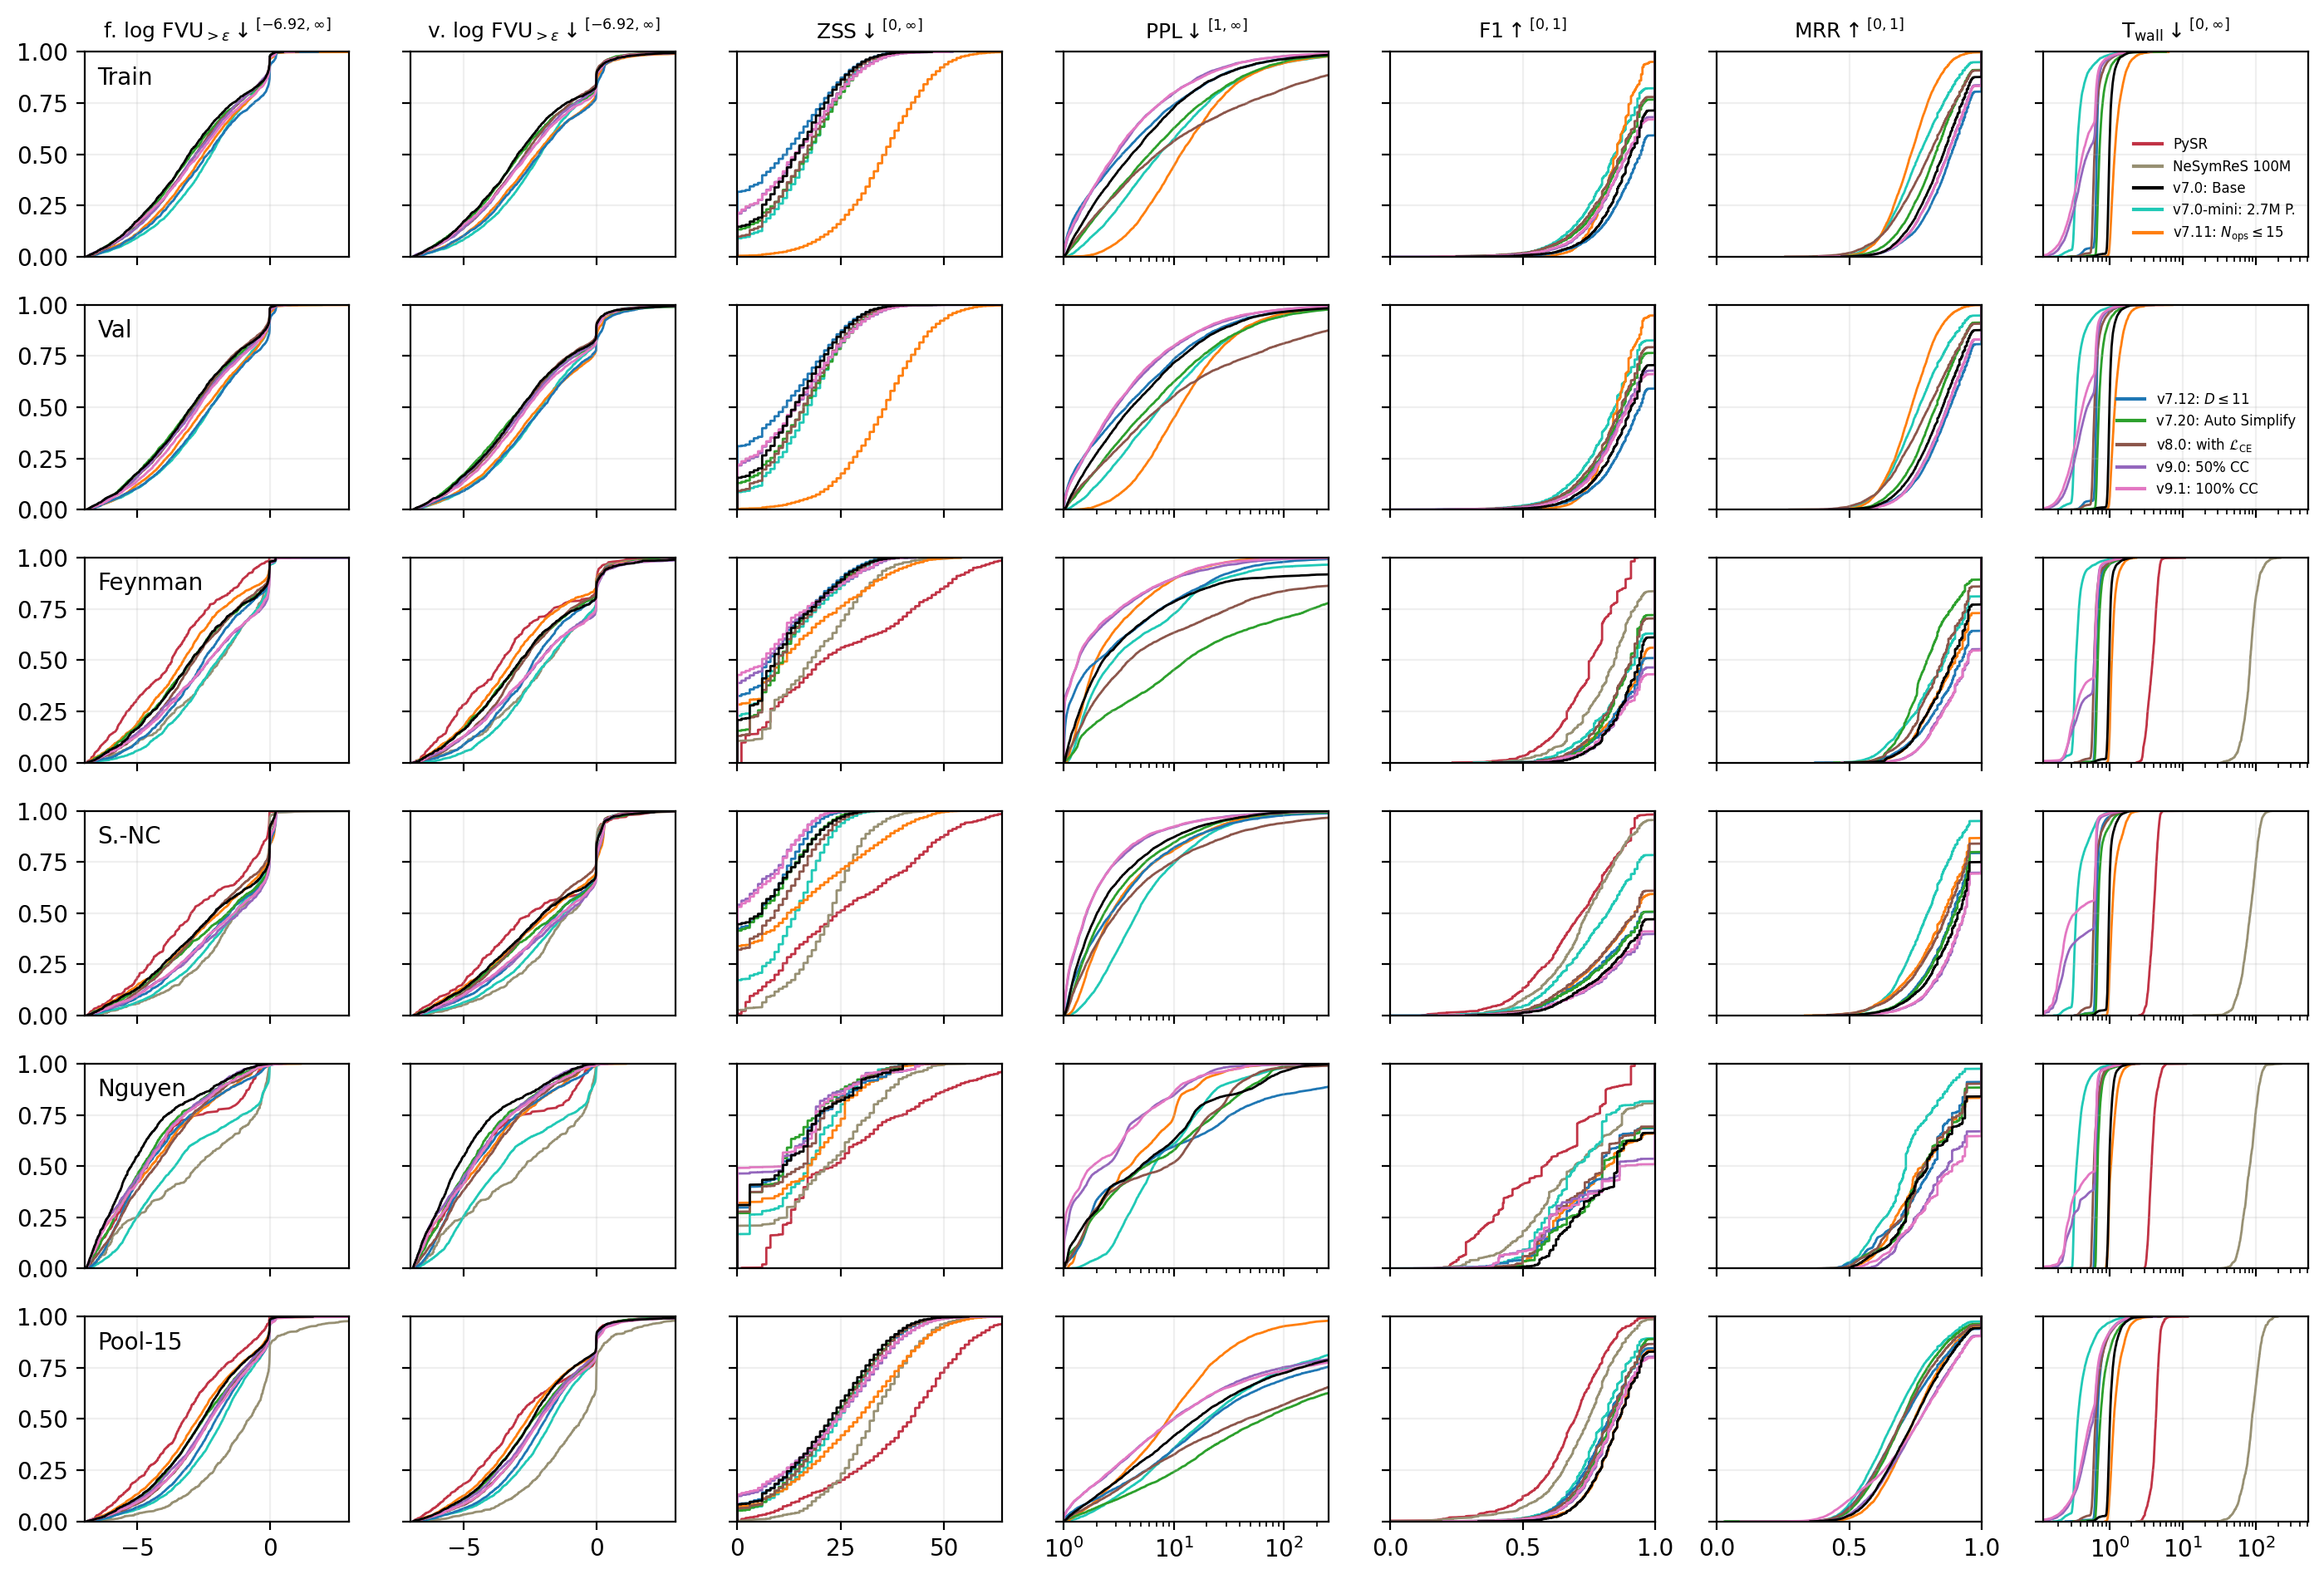

In [150]:
showcase_columns = ['log_fvu_not_epsilon',  'log_fvu_not_epsilon_val', 'tree_edit_distance_best_beam', 'perplexity', 'f1_score_best_beam', 'reciprocal_rank', 'wall_time']
xlims = [(-7, 3), (-7, 3), (0, 64), (1, 256), (0, 1), (0, 1), (1/8, 512)]
scale = ('linear', 'linear', 'linear', 'log', 'linear', 'linear', 'log')

metric_aliases = {
    "log_fvu_not_epsilon": '$\\text{f. log FVU}_{> \epsilon}\\downarrow^{[' + f'{np.log10(np.finfo(np.float32).eps):.2f}' + r', \infty]}$',
    "log_fvu_not_epsilon_val": '$\\text{v. log FVU}_{> \epsilon}\\downarrow^{[' + f'{np.log10(np.finfo(np.float32).eps):.2f}' + r', \infty]}$',
    "tree_edit_distance_best_beam":	'$\\text{ZSS}\\downarrow^{[0, \infty]}$',
    "perplexity": '$\\text{PPL}\\downarrow^{[1, \infty]}$',
    "f1_score_best_beam": '$\\text{F1}\\uparrow^{[0, 1]}$',
    "reciprocal_rank": '$\\text{MRR}\\uparrow^{[0, 1]}$',
    "wall_time": '$\\text{T}_\\text{wall}\\downarrow^{[0, \infty]}$',
}

model_aliases_latex = {
    'pysr': 'PySR',
    'nesymres-100M': 'NeSymReS 100M',
    'v7.0': 'v7.0: Base',
    'v7.0-mini': 'v7.0-mini: 2.7M P.',
    'v7.11': 'v7.11: $N_\\text{ops} \\leq 15$',
    'v7.12': 'v7.12: $D \\leq 11$',
    'v7.20': 'v7.20: Auto Simplify',
    'v8.0': 'v8.0: with $\\mathcal{L}_\\text{CE}$',
    'v9.0': 'v9.0: 50% CC',
    'v9.1': 'v9.1: 100% CC',
}

model_colors = {
    'pysr': '#c13345',
    'nesymres-100M': '#979073',
    'v7.0': 'k',
    'v7.0-mini': '#20C9B6',
    'v7.11': 'tab:orange',
    'v7.12': 'tab:blue',
    'v7.20': 'tab:green',
    'v8.0': 'tab:brown',
    'v9.0': 'tab:purple',
    'v9.1': 'tab:pink',
}

ROWS = len(TEST_SET_TITLES)
COLS = len(showcase_columns)

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 2, ROWS * 1.6), dpi=200, sharey=True, sharex='col')

for row, test_set in enumerate(TEST_SET_TITLES):
    axes[row, 0].annotate(f'{TEST_SET_TITLES[test_set]}', xy=(0.05, 0.93), xycoords='axes fraction', ha='left', va='top', color='k')
    for col, column in enumerate(showcase_columns):
        axes[0, col].set_title(metric_aliases.get(column, column), fontsize=9)
        for model, model_dfs in array_dfs.items():
            if test_set not in model_dfs:
                continue
            test_set_dfs = model_dfs[test_set]
            if column not in test_set_dfs.columns:
                continue
            valid_mask = np.isfinite(test_set_dfs[column].values)
            cdf_values = np.linspace(0, 1, valid_mask.sum())
            axes[row, col].plot(np.sort(test_set_dfs[column].values[valid_mask]), cdf_values, zorder=2 if model == 'v7.0' else 1, color=model_colors[model], linewidth=1)
        axes[row, col].set_xlim(xlims[col])
        axes[row, col].set_xscale(scale[col])
        axes[row, col].set_ylim(0, 1)
        axes[row, col].grid(alpha=0.2)

# Add a legend to the first subplot
for model in list(model_colors.keys())[:5]:
    axes[0, -1].plot([], [], label=model_aliases_latex[model], color=model_colors[model], linewidth=1.5)
axes[0, -1].legend(loc='lower right', fontsize=6, frameon=False)

# Add a legend to the first subplot
for model in list(model_colors.keys())[5:]:
    axes[1, -1].plot([], [], label=model_aliases_latex[model], color=model_colors[model], linewidth=1.5)
axes[1, -1].legend(loc='lower right', fontsize=6, frameon=False)

fig.tight_layout()

plt.savefig(get_path('results', 'main', create=True, filename='CDFs_2.svg'), bbox_inches='tight')